# Tweets Data Analysis
## Goal of Analysis: Use machine learning algorithms to classify the mood and tweet related topics 

In [111]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import networkx as nx
import re
import math
import random
import pyLDAvis
import pyLDAvis.gensim
import gensim
import spacy

from spacy import load
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel


from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tag import pos_tag
from scipy.stats import mannwhitneyu, mood, ks_2samp, pearsonr, pointbiserialr

from textblob import TextBlob
from nrclex import NRCLex
from collections import Counter
from afinn import Afinn

ImportError: cannot import name 'neg_tag' from 'nltk.tag' (C:\Users\igorr\AppData\Roaming\Python\Python38\site-packages\nltk\tag\__init__.py)

## Preprocessing section 

### Reading data and set settings

- jupyter-settings

In [5]:
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

- preparing-access

In [6]:
#reading data
tweets = pd.read_csv("assets/tweets.csv", encoding="latin1")
tweets

Target          ID                          Date      flag             User                                               Text
0             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton  is upset that he can't update his Facebook by ...
1             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus  @Kenichan I dived many times for the ball. Man...
2             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF    my whole body feels itchy and like its on fire 
3             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli  @nationwideclass no, it's not behaving at all....
4             0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY         joy_wolf                      @Kwesidei not the whole crew 
5             0  1467811592  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY          mybirch                                        Need a hug 
6             0  1467811594  Mon Apr 06 22:20:03 PDT 2009  NO_QUERY             coZZ  @LOLTrish hey  long time no see! Yes.. Rains a...
7             0  1467811795  Mon Apr 06 22:20:05 PDT 2009  NO_QUERY  2Hood4Hollywood               @Tatiana_K nope they didn't have it 
8             0  1467812025  Mon Apr 06 22:20:09 PDT 2009  NO_QUERY          mimismo                          @twittera que me muera ? 
9             0  1467812416  Mon Apr 06 22:20:16 PDT 2009  NO_QUERY   erinx3leannexo        spring break in plain city... it's snowing 
...         ...         ...                           ...       ...              ...                                                ...
1048565       4  1960185825  Fri May 29 07:33:40 PDT 2009  NO_QUERY         ahousley  Looking forward to a mini-break in Isle of Wig...
1048566       4  1960185836  Fri May 29 07:33:40 PDT 2009  NO_QUERY  WindmillBrixton  GRINGO STAR tonight. Southern garage.  http://...
1048567       4  1960185847  Fri May 29 07:33:40 PDT 2009  NO_QUERY        techcoach  @DavidBass hee hee...I'll take rain over wind ...
1048568       4  1960185945  Fri May 29 07:33:41 PDT 2009  NO_QUERY          timg888  today's message in the church service was deli...
1048569       4  1960186091  Fri May 29 07:33:42 PDT 2009  NO_QUERY      debraladiva  Back home, thought I'd done for the week, but ...
1048570       4  1960186342  Fri May 29 07:33:44 PDT 2009  NO_QUERY  Madelinedugganx           My GrandMa is making Dinenr with my Mum 
1048571       4  1960186409  Fri May 29 07:33:43 PDT 2009  NO_QUERY     OffRoad_Dude  Mid-morning snack time... A bowl of cheese noo...
1048572       4  1960186429  Fri May 29 07:33:44 PDT 2009  NO_QUERY         Falchion  @ShaDeLa same here  say it like from the Termi...
1048573       4  1960186445  Fri May 29 07:33:44 PDT 2009  NO_QUERY   jonasobsessedx             @DestinyHope92 im great thaanks  wbuu?
1048574       4  1960186607  Fri May 29 07:33:45 PDT 2009  NO_QUERY        sugababez               cant wait til her date this weekend 

[1048575 rows x 6 columns]

### First insights and data cleaning

- insights

In [7]:
#types of data in column, needed later for substitute
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Target  1048575 non-null  int64 
 1   ID      1048575 non-null  int64 
 2   Date    1048575 non-null  object
 3   flag    1048575 non-null  object
 4   User    1048575 non-null  object
 5   Text    1048575 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [8]:
#before building our model we must understand what are our desires and what columns are needed
tweets.columns

Index(['Target', 'ID', 'Date', 'flag', 'User', 'Text'], dtype='object')

In [9]:
#the first model needs only `Target` and `Text`
tweets_df = tweets.drop(tweets.columns[1:5], axis=1)
tweets_df['Target'].unique()
#seems pointless to have values 0 and 4 let's change appearing 4's to 1's.
tweets_df['Target'].replace([4], 1, inplace=True)

#splitting data for development and validation team
dev_df, val_df = train_test_split(tweets_df, test_size=0.3, random_state=42)
dev_train_df, dev_val_df = train_test_split(dev_df, test_size=0.3, random_state=42)

tweets_df= dev_train_df

- data cleaning and in it preprocessing

1. removing special chars and punctuation marks
2. text tokenization
3. text normalization
4. deleting meaningless words
5. lemmatization

In [10]:
#1. removing special chars and punctutation marks
# if char not in ABC... and not in abc... and is not ' ','' or "'"(apostrophe for can't, it's etc), then substitute with ' '

allowed_characters = set(chr(i) for i in range(256) if chr(i).isalpha())

def filter_characters(text):
    considering_text=''
    for character in text:
        if character in allowed_characters or character==' ' or character=='' or character=="'":
            considering_text+=character
        else:
            considering_text+=' '
    return considering_text

def extra_spaces_remover(text):
    text_to_change = re.sub(r'\s+', ' ', text)
    changed_text = text_to_change.strip()
    return changed_text

#removing additionals ' ', if there are more then 1 ' ' chars next to each other substitute it with single ' '

tweets_df['Text']= tweets_df['Text'].apply(filter_characters, extra_spaces_remover)

tweets_df.head()

Target                                               Text
810677       1  working  listening to KMPS  happy my boss  amp...
684982       0    We both know she is late for  quot at    quot  
954730       1  don't bogart that joint my friend    http   bl...
142760       0  I'm so sick of being sick  I don't want to mis...
200331       0  im pretty sure i went to bed about      hours ...

In [11]:
#2. text tokenization
#simply by using `split` method

def eng_tokenization(text):
    return text.split()

tweets_df['tokens']= tweets_df['Text'].apply(eng_tokenization)

tweets_df.head()

Target                                               Text                                             tokens
810677       1  working  listening to KMPS  happy my boss  amp...  [working, listening, to, KMPS, happy, my, boss...
684982       0    We both know she is late for  quot at    quot    [We, both, know, she, is, late, for, quot, at,...
954730       1  don't bogart that joint my friend    http   bl...  [don't, bogart, that, joint, my, friend, http,...
142760       0  I'm so sick of being sick  I don't want to mis...  [I'm, so, sick, of, being, sick, I, don't, wan...
200331       0  im pretty sure i went to bed about      hours ...  [im, pretty, sure, i, went, to, bed, about, ho...

In [12]:
#3. text normalization
#simply by forcing letters to be in lowercase format

def eng_normalization(arr):
    tokens=[]
    for word in arr:
        tokens.append(word.lower())
    return tokens

tweets_df['tokens']= tweets_df['tokens'].apply(eng_normalization)

In [13]:
#4. deleting meaningless words
#we want to delete stop words, such as: "and", "in", "also" etc
#we are using here NLTK(Natural Language Toolkit) library from which we gain access of stop words

import nltk
from nltk.corpus import stopwords

#one's may need to download these list of stop words
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

tweets_df['tokens']= tweets_df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

tweets_df.head()

Target                                               Text                                             tokens
810677       1  working  listening to KMPS  happy my boss  amp...  [working, listening, kmps, happy, boss, amp, m...
684982       0    We both know she is late for  quot at    quot                             [know, late, quot, quot]
954730       1  don't bogart that joint my friend    http   bl...        [bogart, joint, friend, http, blip, fm, gg]
142760       0  I'm so sick of being sick  I don't want to mis...     [i'm, sick, sick, want, miss, another, summer]
200331       0  im pretty sure i went to bed about      hours ...  [im, pretty, sure, went, bed, hours, ago, im, ...

In [14]:
#5. lemmatization(break a word down to its root meaning to identify similarities) Examples: "better"->"good", "walking"->"walk"
#before making lemmatization we have to know which part of speech the word is: verb, noun, adjective, adverb

#one's may need to download these list of data
#nltk.download('averaged_perceptron_tagger')

def part_of_speech_classifier(tokens):
    return pos_tag(tokens)

tweets_df['tags']= tweets_df['tokens'].apply(part_of_speech_classifier)

tweets_df.head()

Target                                               Text                                             tokens                                               tags
810677       1  working  listening to KMPS  happy my boss  amp...  [working, listening, kmps, happy, boss, amp, m...  [(working, VBG), (listening, VBG), (kmps, NNS)...
684982       0    We both know she is late for  quot at    quot                             [know, late, quot, quot]  [(know, VB), (late, JJ), (quot, NNS), (quot, NN)]
954730       1  don't bogart that joint my friend    http   bl...        [bogart, joint, friend, http, blip, fm, gg]  [(bogart, RB), (joint, JJ), (friend, NN), (htt...
142760       0  I'm so sick of being sick  I don't want to mis...     [i'm, sick, sick, want, miss, another, summer]  [(i'm, NN), (sick, JJ), (sick, NN), (want, VBP...
200331       0  im pretty sure i went to bed about      hours ...  [im, pretty, sure, went, bed, hours, ago, im, ...  [(im, NN), (pretty, RB), (sure, JJ), (went, VB...

In [15]:
#now we may lemmatize using method from nltk package
#additional info: we could not determinate part of speech and just lemmatize, and then setting specific lemma for each word(the first found lemma), but that approach
#is worse then the one with using `tags` information, beacuse now we can find exact lemma for each word(not the first found one, but the exact one)

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tags):
    lemmatized_tokens = []
    for tok, tag in tags:
        if tag.startswith('N'):
            lemmatized_tokens.append(lemmatizer.lemmatize(tok, pos='n'))
        elif tag.startswith('V'):
            lemmatized_tokens.append(lemmatizer.lemmatize(tok, pos='v'))
        elif tag.startswith('J'):
            lemmatized_tokens.append(lemmatizer.lemmatize(tok, pos='a'))
        elif tag.startswith('R'):
            lemmatized_tokens.append(lemmatizer.lemmatize(tok, pos='r'))
        else:
            lemmatized_tokens.append(tok) #in case if different type of speech
    return lemmatized_tokens

tweets_df['lemmatized_tokens'] = tweets_df['tags'].apply(lemmatize_tokens)
tweets_df.head()


Target                                               Text                                             tokens                                               tags                                  lemmatized_tokens
810677       1  working  listening to KMPS  happy my boss  amp...  [working, listening, kmps, happy, boss, amp, m...  [(working, VBG), (listening, VBG), (kmps, NNS)...  [work, listen, kmps, happy, boss, amp, mechani...
684982       0    We both know she is late for  quot at    quot                             [know, late, quot, quot]  [(know, VB), (late, JJ), (quot, NNS), (quot, NN)]                           [know, late, quot, quot]
954730       1  don't bogart that joint my friend    http   bl...        [bogart, joint, friend, http, blip, fm, gg]  [(bogart, RB), (joint, JJ), (friend, NN), (htt...        [bogart, joint, friend, http, blip, fm, gg]
142760       0  I'm so sick of being sick  I don't want to mis...     [i'm, sick, sick, want, miss, another, summer]  [(i'm, NN), (sick, JJ), (sick, NN), (want, VBP...     [i'm, sick, sick, want, miss, another, summer]
200331       0  im pretty sure i went to bed about      hours ...  [im, pretty, sure, went, bed, hours, ago, im, ...  [(im, NN), (pretty, RB), (sure, JJ), (went, VB...   [im, pretty, sure, go, bed, hour, ago, im, ahhh]

## Data analysis and trends finding 

### Sentiment distribution analysis


- Sentiment distribution

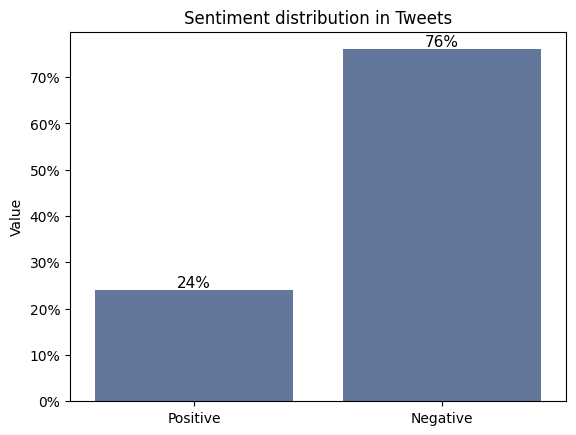

In [13]:
#the first step is to understand whether tweets tend to be positive or negative in general, that will help us
#determinate the mood on this social media platform for majory of people


positive_attitudes=tweets_df['Target'][tweets_df['Target']==1].count()
negative_attitudes=tweets_df['Target'][tweets_df['Target']==0].count()

all_records= tweets_df.shape[0]

sentiment_distribution= {'Target': ['Positive', 'Negative'], 'Value': 
                         [round(positive_attitudes/all_records, 2)*100, round(negative_attitudes/all_records, 2)*100]}

sentiment_distribution_df= pd.DataFrame(sentiment_distribution)

ax= sns.barplot(data= sentiment_distribution_df, x= "Target", y="Value", color="#5975A4")

ax.set(title="Sentiment distribution in Tweets")

def percent(x, pos):
    return '%1.0f%%' % x

ax.yaxis.set_major_formatter(ticker.FuncFormatter(percent))

ax.set_xlabel("")

for p in ax.patches:
    value = str(p.get_height()).rstrip('0').rstrip('.')
    ax.annotate(f'{value}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Length of statements analysis


- Length distribution correlated with attidute

1. determining the length of lemmatized tokens
2. study of the average length of utterances
3. visualization of group distributions lengths of lemmatized tokens
4. statistical tests(Mann–Whitney U test, Mood test)
5. correlation analysis

In [52]:
#the first step is to determinate whether in specific group the number of words per sentiment differ
tweets_df['words_counted']= tweets_df['lemmatized_tokens'].apply(lambda x: len(x))
avg_words_statement=tweets_df.groupby(['Target']).apply(lambda x: round(x['words_counted'].sum()/len(x), 3))

avg_words_statement

Target
0    7.939
1    7.962
dtype: float64

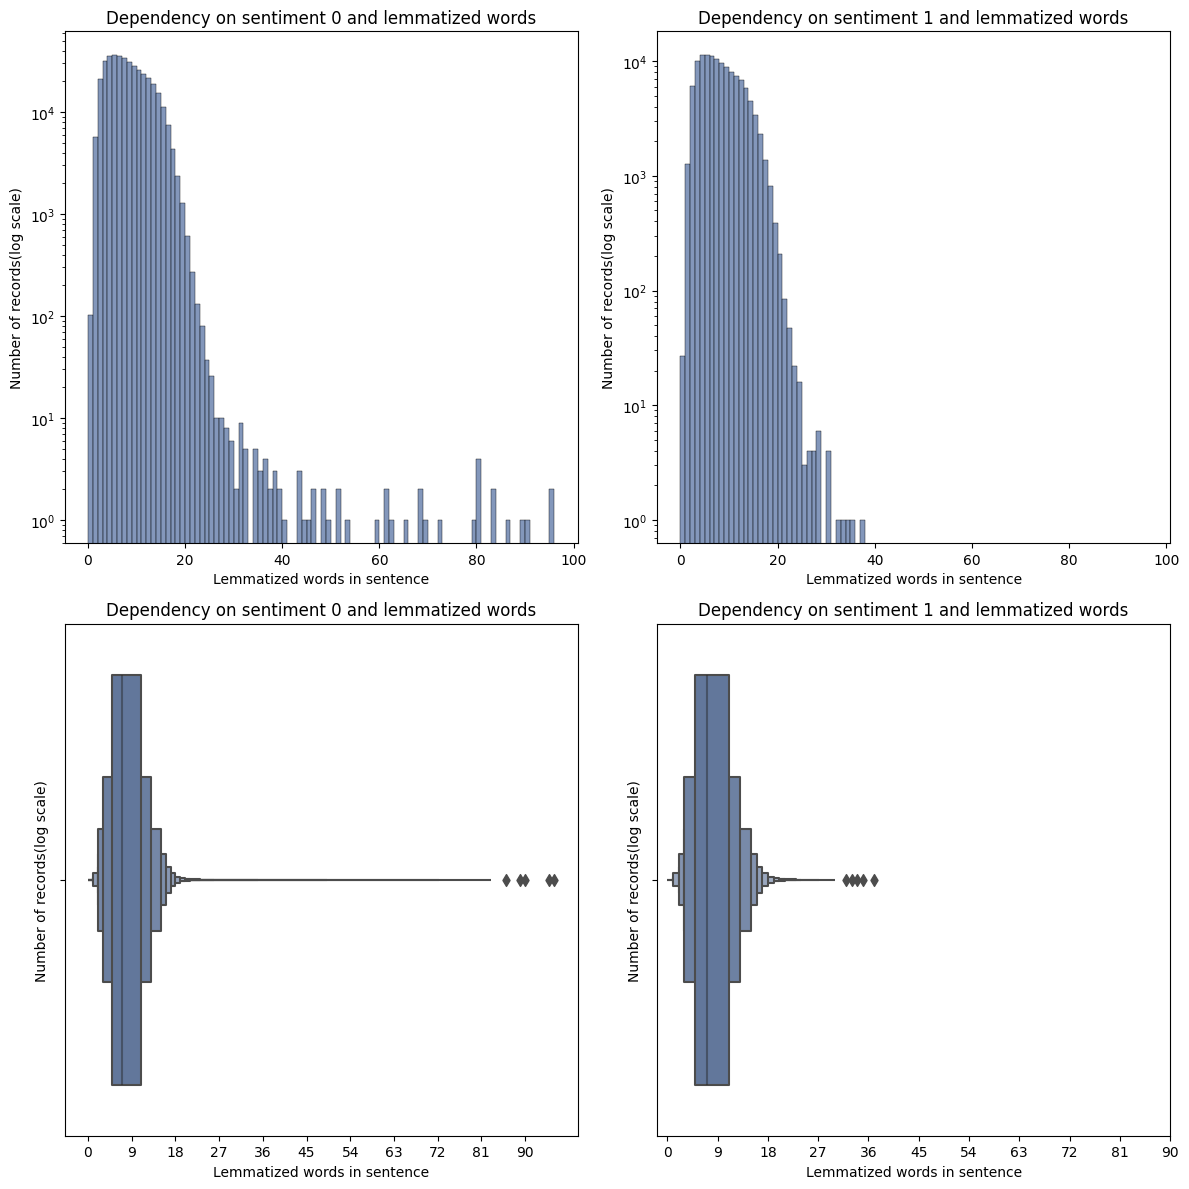

In [53]:
negative_df = tweets_df[tweets_df['Target'] == 0]
positive_df = tweets_df[tweets_df['Target'] == 1]

color = '#5975A4'

# setting range on x axes
bins_range = (0, max(max(negative_df['words_counted']), max(positive_df['words_counted'])))

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# histogram for bad sentiment
sns.histplot(negative_df['words_counted'], ax=axes[0, 0], color=color, bins=bins_range[1], binrange=bins_range)
axes[0, 0].set_title('Dependency on sentiment 0 and lemmatized words')
axes[0, 0].set_xlabel('Lemmatized words in sentence')
axes[0, 0].set_ylabel('Number of records(log scale)')
axes[0, 0].set_yscale('log')  # logarithm of corresponding values

# histogram for good sentiment
sns.histplot(positive_df['words_counted'], ax=axes[0, 1], color=color, bins=bins_range[1], binrange=bins_range)
axes[0, 1].set_title('Dependency on sentiment 1 and lemmatized words')
axes[0, 1].set_xlabel('Lemmatized words in sentence')
axes[0, 1].set_ylabel('Number of records(log scale)')
axes[0, 1].set_yscale('log')  # logarithm of corresponding values

# boxenplot for bad sentiment
sns.boxenplot(x=negative_df['words_counted'], ax=axes[1, 0], color=color, width=0.8)
axes[1, 0].set_title('Dependency on sentiment 0 and lemmatized words')
axes[1, 0].set_xlabel('Lemmatized words in sentence')
axes[1, 0].set_ylabel('Number of records(log scale)')
axes[1, 0].set_xticks(range(0, bins_range[1], bins_range[1] // 10))  # setting appearing values on x axes

# histogram for good sentiment
sns.boxenplot(x=positive_df['words_counted'], ax=axes[1, 1], color=color, width=0.8)
axes[1, 1].set_title('Dependency on sentiment 1 and lemmatized words')
axes[1, 1].set_xlabel('Lemmatized words in sentence')
axes[1, 1].set_ylabel('Number of records(log scale)')
axes[1, 1].set_xticks(range(0, bins_range[1], bins_range[1] // 10))  # setting appearing values on x axes

plt.tight_layout()
plt.show()


In [54]:
#statistical tests, will help us determinate, wheter difference in records in groups is due to accident
#or real difference among records

#we can't use t-Student's test due to the fact that distribution of sentiments is not a normal distribution(to use t-Student's test
#we have to make sure that values are from normal distribution)
#that's why we will use Mann-Whitney U test

negative_statiment = tweets_df[tweets_df['Target'] == 0]['words_counted']
positive_statiment = tweets_df[tweets_df['Target'] == 1]['words_counted']

statistics, p_value= mannwhitneyu(negative_statiment, positive_statiment)

mann_whitney_result= {"statistics": statistics, "p_value": p_value}
mann_whitney_df = pd.DataFrame(mann_whitney_result, index=['Mann-Whitney Result'])

mann_whitney_df

statistics   p_value
Mann-Whitney Result  2.375751e+10  0.033143

In [55]:
#due to value p= 0.000001 we may interpret it as there are 
#statistically significant differences between the groups in the context of the length of the statement
#in our interpretation we used the convention that if p< 0.05 then we reject the null hypothesis and there must be some differences among records
#and the groups they belong to

#To make sure of our beliefs, we will also use the mood test
statistic, p_value = mood(negative_statiment, positive_statiment)

moods_result= {"statistics": statistics, "p_value": p_value}
moods_df = pd.DataFrame(moods_result, index=['Moods Result'])

#In the Mood test the p_value will determinate the probability that the same result will be given if we have the same distribution
#the very low value tells us that we have different distributions
moods_df

statistics       p_value
Moods Result  2.375751e+10  1.064957e-08

In [56]:
#correlation analysis between statiment and amount of words

correlation, p= pearsonr(tweets_df['words_counted'], tweets_df['Target'])
correlation_df= pd.DataFrame({"Correlation":correlation}, index= ["Correlation result"])

correlation_df

Correlation
Correlation result     0.002411

In [19]:
#conclusions drawn from statistical tests and correlation analysis:
#there is a non-accidental difference between groups of statistics, but there is no simple relationship that can be determined using correlation

### Frequency of words analysis

1. finding most positive and negative words used in each statiment with results shown
2. comparision of most frequent positive words and their equivalent, the same for negative and equivalents
3. table analysis of percentege of data for words appearing more often in negative statiment and demonstration of possible reason
4. emotion prediction for words appearing in scalars(check third point)
5. collocation analysis for bigrams(graph representations and differences with words embedding)

- most frquently used positive and negative words visualization

In [57]:
#first let's make a usefull dictonaries containing words counters for each statiment

from collections import Counter

positive_words= []
negative_words= [] 

for words in tweets_df[tweets_df['Target']==1]['lemmatized_tokens']:
    positive_words.extend(words)
for words in tweets_df[tweets_df['Target']==0]['lemmatized_tokens']:
    negative_words.extend(words)

positive_words_frequency= Counter(positive_words)
negative_words_frequency= Counter(negative_words)

df_positive_words= pd.DataFrame.from_dict(positive_words_frequency, orient="index").reset_index()
df_negative_words= pd.DataFrame.from_dict(negative_words_frequency, orient="index").reset_index()

df_positive_words.rename(columns={"index":"positive_word", 0:"amount"}, inplace=True)
df_negative_words.rename(columns={"index":"negative_word", 0:"amount"},inplace=True)

df_positive_words.sort_values(by= "amount", ascending=False, inplace=True)
df_negative_words.sort_values(by= "amount", ascending=False, inplace=True)

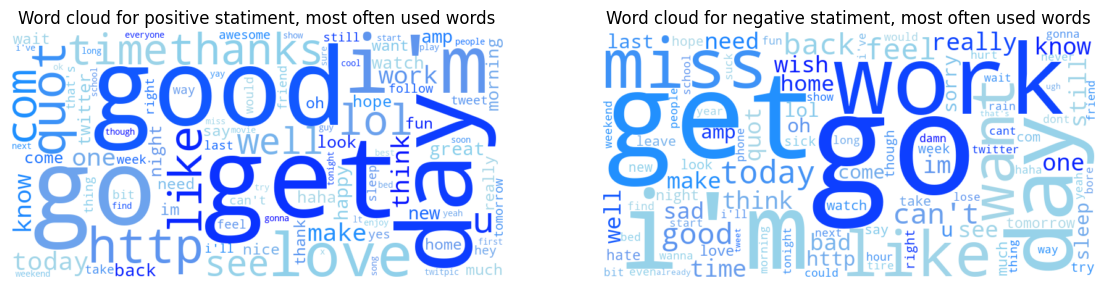

In [58]:
#now basic visualization to see if there are words which are more often used in spacific statiment

from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap

colors = ['#ADD8E6', '#87CEEB', '#6495ED', '#1E90FF', '#0000FF']
blue_gradient_map = LinearSegmentedColormap.from_list('blue_gradient', colors)

positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=blue_gradient_map) \
                        .generate_from_frequencies(dict(df_positive_words[:100].values))

negative_wordcloud= WordCloud(width=800, height=400, background_color='white', colormap=blue_gradient_map) \
                    .generate_from_frequencies(dict(df_negative_words[:100].values))

plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)

plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Word cloud for positive statiment, most often used words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word cloud for negative statiment, most often used words')
plt.axis('off')

plt.show()

- comparision of most frequent positive words and their equivalent(the same goes for negatives)

C:\Users\igorr\AppData\Local\Temp\ipykernel_4644\3410825210.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positve_words['source'] = 'positive'
C:\Users\igorr\AppData\Local\Temp\ipykernel_4644\3410825210.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_words2['source']= 'negative'


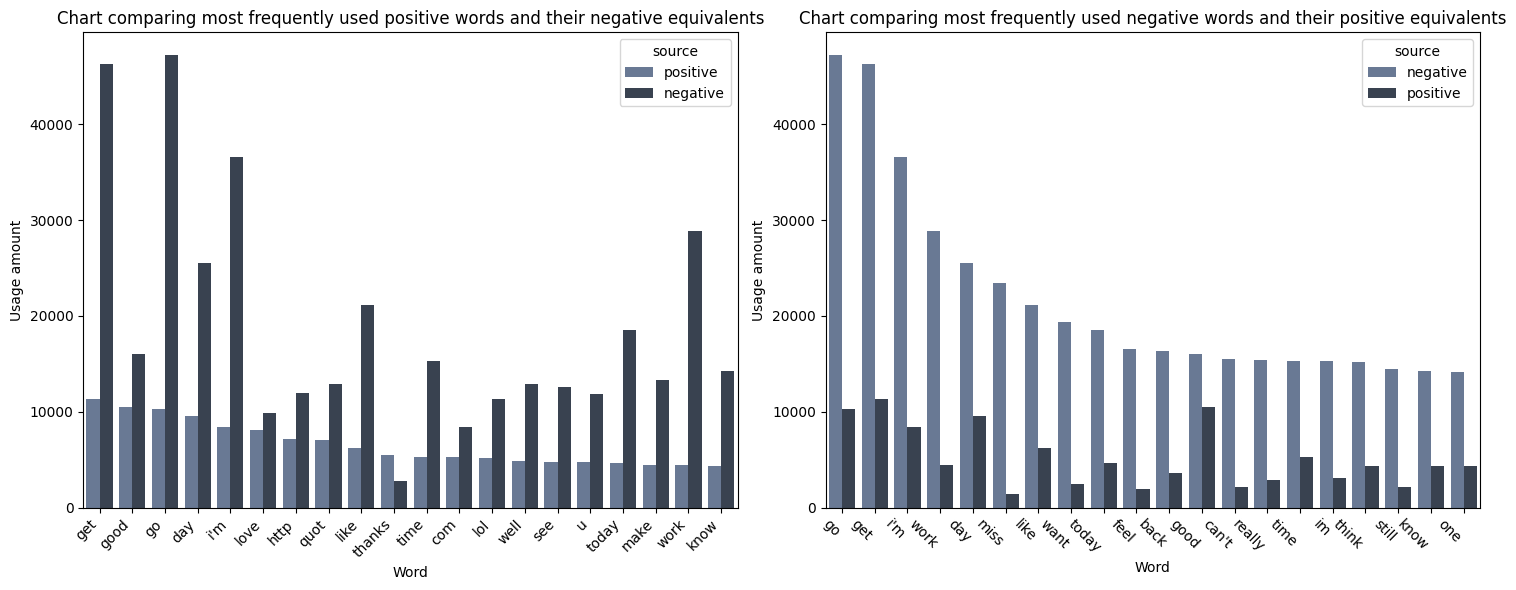

In [59]:
#it's better to compare 100 most often used words for each statiment in more visible way

most_positive_words_set= df_positive_words[:20]['positive_word']
most_negative_words_set= df_negative_words[:20]['negative_word']

contrast_to_positive_words= df_negative_words[df_negative_words['negative_word'].isin(most_positive_words_set)]
contrast_to_negative_words= df_positive_words[df_positive_words['positive_word'].isin(most_negative_words_set)]


negative_words= pd.DataFrame({"positive_word": contrast_to_positive_words['negative_word'], "amount": contrast_to_positive_words['amount']})
positve_words= df_positive_words[:20]

positive_words2= pd.DataFrame({"negative_word": contrast_to_negative_words['positive_word'], 'amount': contrast_to_negative_words['amount']})
negative_words2= df_negative_words[:20]

positve_words['source'] = 'positive'
negative_words['source'] = 'negative'

negative_words2['source']= 'negative'
positive_words2['source']= 'positive'

merged_data = pd.concat([positve_words, negative_words])
merged_data2= pd.concat([negative_words2, positive_words2])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(ax= axes[0], x='positive_word', y='amount', hue='source', data=merged_data, palette={'positive': '#62779B', 'negative': '#354154'})

axes[0].set_xlabel('Word')
axes[0].set_ylabel('Usage amount')
axes[0].set_title('Chart comparing most frequently used positive words and their negative equivalents')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

sns.barplot(ax= axes[1], data=merged_data2, x="negative_word", y='amount', hue='source', palette={'negative': '#62779B', 'positive': '#354154'})

axes[1].set_xlabel('Word')
axes[1].set_ylabel('Usage amount')
axes[1].set_title('Chart comparing most frequently used negative words and their positive equivalents')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=315, ha='right')


plt.tight_layout()
plt.show()

- dividing words into their greater popularity in a negative use case and thier's probabilistic selection of groups

In [60]:
#the possible insight of right plot can be made much easier then the left one. 
#Quick question arising: how many percentege of words tend to look like right plot(words used more than twice as often in a given statiment)

pos_neg_df = pd.merge(df_negative_words, df_positive_words, left_on='negative_word', right_on='positive_word', how='left')

pos_neg_df.rename({'negative_word': "word"}, inplace=True)
pos_neg_df.drop('positive_word', axis=1, inplace=True)
pos_neg_df['indicator']= pos_neg_df['amount_x']/pos_neg_df['amount_y']
pos_neg_df.drop(['amount_x', 'amount_y'], axis=1, inplace=True)

#considering only non NaN records
pos_neg_df= pos_neg_df[pos_neg_df['indicator'].notna()]

rows=pos_neg_df.shape[0]

summary_df = pd.DataFrame()
for i in range(1, 21):  # Przykładowo od 1 do 10
    count = pos_neg_df[pos_neg_df['indicator'] > i].shape[0]
    summary_df = pd.concat([summary_df, pd.DataFrame({'indicator_value': [i], 'count': [count]})], ignore_index=True)

summary_df['count']= summary_df['count'].apply(lambda x: x/rows*100)

summary_df
#we thus determine the probability from the uniform distribution of data that a 
#randomly selected word will appear (more than) indicator_value times more often in sentiment 0 than in sentiment 1

#for example: there is around 36.643908 percentage chance that a random word will appear more then twice time often in sentiment 0 sentence then in sentiment 1 sentence

indicator_value      count
0                 1  60.207769
1                 2  38.105992
2                 3  24.097733
3                 4  15.890222
4                 5  10.908934
5                 6   7.727879
6                 7   5.869575
7                 8   4.602744
8                 9   3.667140
9                10   2.991784
10               11   2.484192
11               12   2.045425
12               13   1.748613
13               14   1.522777
14               15   1.346410
15               16   1.200155
16               17   1.051749
17               18   0.946359
18               19   0.838818
19               20   0.785048

- negative words group interpretation 

In [61]:
specific_neg = {20: [], 19: [], 18: [], 17: [], 16: [], 15: [], 14: [], 13: [], 12: [], 11: [], 10: []}

def specific_words_appender(record):
    val = math.floor(record['indicator'])
    if val >= 10:
        if val >= 20:
            valSpec = 20
        else:
            valSpec = val
        en_set = specific_neg[valSpec]
        en_set.append(record['negative_word'])
        specific_neg[valSpec] = en_set

for index, row in pos_neg_df.iterrows():
    specific_words_appender(row)

specific_neg_df = pd.DataFrame(list(specific_neg.items()), columns=['scalar', 'negative_words'])

specific_neg_df

scalar                                     negative_words
0       20  [sad, hate, sick, suck, hurt, ugh, poor, cry, ...
1       19  [worst, gloomy, divorce, wrist, broke, unable,...
2       18  [stuck, ughh, swell, bleed, neglect, huhu, des...
3       17  [anymore, goodbye, ruin, nose, conan, yucky, p...
4       16  [miss, stupid, pain, cough, sims, afford, disa...
5       15  [wont, battery, crappy, nooo, painful, dread, ...
6       14  [fail, boo, scar, wtf, father, gah, ankle, rub...
7       13  [bad, lose, die, tear, empty, mtv, nightmare, ...
8       12  [sorry, damn, cold, alone, crap, sigh, hospita...
9       11  [bore, hungry, fell, doesnt, boring, piss, kne...
10      10  [wish, didnt, kill, dead, crash, leg, forgot, ...

In [25]:
#the first glance allows us to intuitively understand what all these words in statiment 0 have in common. First of all, they touch on emotional topics
#The bigger the scalar is the more negative associations the given words have, to the point that the have only negative meaning

- emotion analysis for negative words groups

In [24]:
#I gained package from https://github.com/cjhutto/vaderSentiment?tab=readme-ov-file#introduction

words_analyse= SentimentIntensityAnalyzer()

negative_percentage_list=[]
neutral_percentage_list=[]
positive_percentage_list=[]

def emotions_finder(record):
    words= record['negative_words']
    
    positive_words= 0
    neutral_words= 0
    negative_words= 0
    
    for word in words:
        sen_score= words_analyse.polarity_scores(word)

        if sen_score['compound'] >=0.05:
            positive_words+=1
        elif -0.05<sen_score['compound']<0.05:
            neutral_words+=1
        else:
            negative_words+=1
    
    positive_percentage_list.append(positive_words/len(words))
    neutral_percentage_list.append(neutral_words/len(words))
    negative_percentage_list.append(negative_words/len(words))

for index, row in specific_neg_df.iterrows():
    emotions_finder(row)

positive_percentage_list= [round(record, 6) for record in positive_percentage_list]
neutral_percentage_list= [round(record, 6) for record in neutral_percentage_list]
negative_percentage_list= [round(record, 6) for record in negative_percentage_list]

specific_neg_df['percentage_negative_by_100']= negative_percentage_list
specific_neg_df['percentage_positive_by_100']= positive_percentage_list
specific_neg_df['percentage_neutral_by_100']= neutral_percentage_list

specific_neg_df

scalar                                     negative_words  percentage_negative_by_100  percentage_positive_by_100  percentage_neutral_by_100
0       20  [sad, hate, sick, suck, hurt, ugh, poor, cry, ...                    0.244737                    0.007895                   0.747368
1       19  [worst, gloomy, divorce, wrist, broke, unable,...                    0.255814                    0.023256                   0.720930
2       18  [stuck, ughh, swell, bleed, neglect, huhu, des...                    0.134615                    0.019231                   0.846154
3       17  [anymore, goodbye, ruin, nose, conan, yucky, p...                    0.163636                    0.018182                   0.818182
4       16  [miss, stupid, pain, cough, sims, afford, disa...                    0.128205                    0.000000                   0.871795
5       15  [wont, battery, crappy, nooo, painful, dread, ...                    0.185714                    0.000000                   0.814286
6       14  [fail, boo, scar, wtf, father, gah, ankle, rub...                    0.195652                    0.010870                   0.793478
7       13  [bad, lose, die, tear, empty, mtv, nightmare, ...                    0.149606                    0.000000                   0.850394
8       12  [sorry, damn, cold, alone, crap, sigh, hospita...                    0.122905                    0.005587                   0.871508
9       11  [bore, hungry, fell, doesnt, boring, piss, kne...                    0.103896                    0.012987                   0.883117
10      10  [wish, didnt, kill, dead, crash, leg, forgot, ...                    0.086331                    0.025180                   0.888489

In [117]:
#We can add to our observations the fact that usually words classified as statiment 0 do not contain positive words if the scalar is large enough

- Collocation analysis(bigrams) with the usage of graphs and words embodding

In [98]:
#Collocation analysis, i.e. analysis of neighboring words
#approach to the problem: we will use statistical method pointwise mutual information PMI to find some collocations between words, the high PMI value will determine collocation

#dividing to n-grams

from nltk.util import ngrams
from nltk.tokenize import word_tokenize

collocations_list=[]

def define_collocations(tokens):
    bigrams= list(ngrams(tokens, 2))
    collocations_list.append(bigrams)

tweets_df['lemmatized_tokens'].apply(define_collocations)

tweets_df['collocations']= collocations_list

negative_collocations=tweets_df[tweets_df['Target']==0]['collocations']
positive_collocations=tweets_df[tweets_df['Target']==1]['collocations']

positive_collocations.reset_index(drop=True, inplace=True)

In [99]:
#finding the most popular bigrams for negative statiment and positive statiment
collocations_list_dict=[{}, {}]

def collocations_counter(records, indicator):
    
    for i in range(len(records)):
        data= records[i]
        for j in range(len(data)):
            tup= data[j]
            if collocations_list_dict[indicator].get(tup) == None:
                collocations_list_dict[indicator][tup]= 1
            else:
                collocations_list_dict[indicator][tup]+= 1

negative_collocations.reset_index(drop=True, inplace=True)               
positive_collocations.reset_index(drop=True, inplace=True)

collocations_counter(negative_collocations, 0)
collocations_counter(positive_collocations, 1)

negative_collocations_dict= pd.DataFrame.from_dict(collocations_list_dict[0], orient='index')
postivive_collocations_dict= pd.DataFrame.from_dict(collocations_list_dict[1], orient='index')

negative_collocations_dict.rename(columns={0:"amount"},inplace=True)
postivive_collocations_dict.rename(columns={0:"amount"},inplace=True)

negative_collocations_dict.sort_values(by='amount', ascending=False,inplace=True)
postivive_collocations_dict.sort_values(by='amount', ascending=False,inplace=True)

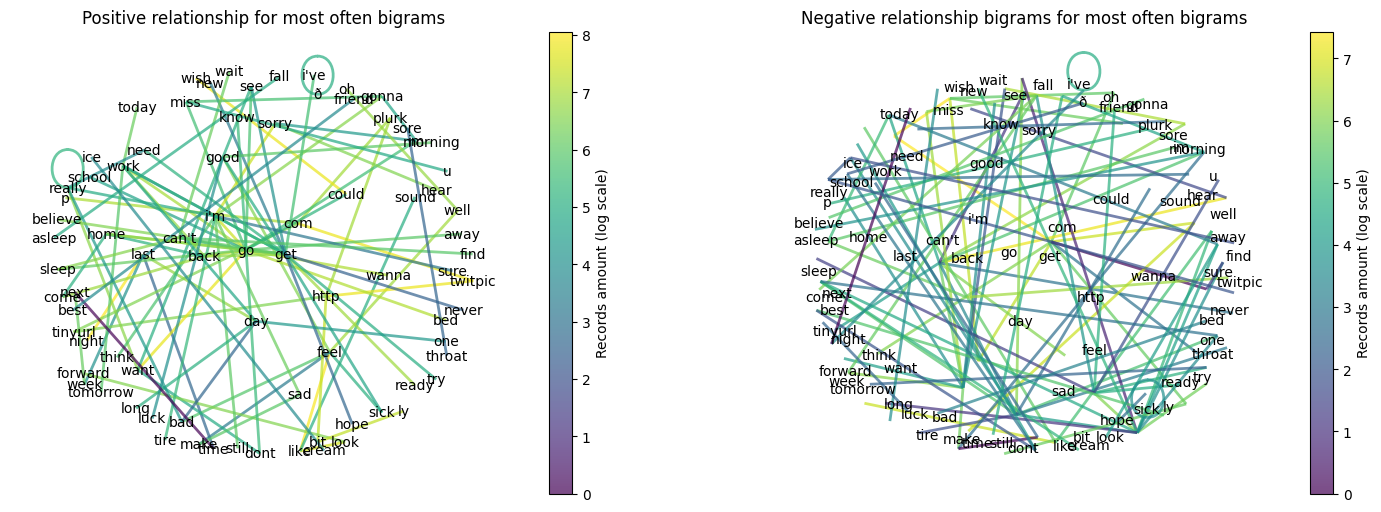

In [27]:
#Graphical analysis of frequency of bigrams, in order to notice the difference about the color density distributions in the bigram modeling graph
G = nx.Graph()
H= nx.Graph()

df= negative_collocations_dict[0:100]
df2= postivive_collocations_dict[0:100]

for idx in df.index:
    G.add_node(idx[0])
    G.add_node(idx[1])

for idx in df2.index:
    H.add_node(idx[0])
    H.add_node(idx[1])

for idx, row in df.iterrows():
    G.add_edge(idx[0], idx[1], weight=row['amount'])

for idx, row in df2.iterrows():
    H.add_edge(idx[0], idx[1], weight=row['amount'])

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].set_title('Positive relationship for most often bigrams')
pos_G = nx.spring_layout(G, k=12)
weights_G = [d['weight'] for u, v, d in G.edges(data=True)]
min_weight_G = min(weights_G)
max_weight_G = max(weights_G)
weights_G = [np.log(w - min_weight_G + 1) for w in weights_G]
labels_G = {node: node for node in G.nodes()}
edges_G = nx.draw_networkx_edges(G, pos_G, ax=axs[0], width=2, edge_color=weights_G, alpha=0.7)
nx.draw_networkx_labels(G, pos_G, labels=labels_G, font_size=10, font_color='black', ax=axs[0])
plt.colorbar(edges_G, ax=axs[0], label='Records amount (log scale)')
axs[0].axis('off')

axs[1].set_title('Negative relationship bigrams for most often bigrams')
pos_H = nx.spring_layout(H, k=12)
weights_H = [d['weight'] for u, v, d in H.edges(data=True)]
min_weight_H = min(weights_H)
max_weight_H = max(weights_H)
weights_H = [np.log(w - min_weight_H + 1) for w in weights_H]
labels_H = {node: node for node in H.nodes()}
edges_H = nx.draw_networkx_edges(H, pos_H, ax=axs[1], width=2, edge_color=weights_H, alpha=0.7)
nx.draw_networkx_labels(G, pos_G, labels=labels_G, font_size=10, font_color='black', ax=axs[1])
plt.colorbar(edges_H, ax=axs[1], label='Records amount (log scale)')
axs[1].axis('off')

plt.show()

In [140]:
#quick insights: the most common sentiment 0 bigrams seems much more difficult to modelate then the positive relationship bigrams,
#comparing whole bigrams set we can conclude from this small sample that the combination of two specific words (forming a bigram)
#in the context of sentiment 1 is not a coincidence. There are phrases that go together to describe a phenomenon. 
#We dedicate such an observation based on the graph's coverage in green. The same cannot be said for using bigrams for statiment 0.


![](network_plot.png)

In [108]:
#as seen above the domination of green area in positive relationship in without question
#but if we consider more and more bigrams in our analysis, the domination of green area will decrease

#out of these 500 bigrams let's take a sample of 200 bigrams and analyse it

small_sample= postivive_collocations_dict.index.to_list()
small_sample2= negative_collocations_dict.index.to_list()

#first semantic analysis

analyzer = SentimentIntensityAnalyzer()
sentiment_scores= []
sentiment_scores2= []

for bigram in small_sample:
    bigram_str = ' '.join(bigram)
    sentiment_scores.append(analyzer.polarity_scores(bigram_str)['pos'])

for bigram in small_sample2:
    bigram_str = ' '.join(bigram)
    sentiment_scores2.append(analyzer.polarity_scores(bigram_str)['neg'])


small_sample_df= pd.DataFrame({'bigram': small_sample, "sentiment_predicator":sentiment_scores })
small_sample2_df= pd.DataFrame({'bigram': small_sample2, "sentiment_predicator":sentiment_scores2 })

values = [round(i * 0.1, 1) for i in range(1, 10)]
probability = [len(small_sample_df[small_sample_df['sentiment_predicator'] >= value])/len(small_sample) for value in values]

probability2=   [len(small_sample2_df[small_sample2_df['sentiment_predicator'] >= value])/len(small_sample2) for value in values]


semantic_results = pd.DataFrame({'sentiment_score': values, 'Probability': probability})
semantic_results2=  pd.DataFrame({'sentiment_score': values, 'Probability': probability2})

semantic_results2

sentiment_score  Probability
0              0.1     0.151720
1              0.2     0.151720
2              0.3     0.151333
3              0.4     0.149846
4              0.5     0.146453
5              0.6     0.129200
6              0.7     0.097871
7              0.8     0.011710
8              0.9     0.006548

In [112]:
from nltk.tag import pos_tag

#second syntatic analysis and frequency of sentence parts

#considering only those recrods which sentime_score positivitiy is >=0.5
small_sample_df_half_positive= small_sample_df[small_sample_df['sentiment_predicator']>=0.5]
small_sample_df_half_negative= small_sample2_df[small_sample2_df['sentiment_predicator']>=0.5]


pos_combinations = []
neg_combinations = []

# deciding the type of sentence
for bigram in small_sample_df_half_positive['bigram']:
    
    tagged_bigram = pos_tag(bigram)
    pos_combinations.append(tuple(tag for _, tag in tagged_bigram))

for bigram in small_sample_df_half_negative['bigram']:
    
    tagged_bigram = pos_tag(bigram)
    neg_combinations.append(tuple(tag for _, tag in tagged_bigram))


pos_combinations_counts = Counter(pos_combinations)
neg_combinations_counts= Counter(neg_combinations)

print("Frequency of types of speech:")
print(pos_combinations_counts)
print(neg_combinations_counts)
print("legend:")
pd.DataFrame({"Shortcut": ['JJ', 'NN', 'VB', 'RB', 'IN', 'MD', 'NNS'], "Explanation": \
                    ['Adjective', 'Noun', 'Base Form Verb', 'Adverb', 'Preposition or subordinating conjunction', 'Modal verb', 'Noun, plural']})

Frequency of types of speech:
Counter({('NN', 'NN'): 54433, ('JJ', 'NN'): 19175, ('NN', 'JJ'): 5795, ('NNS', 'VBP'): 5673, ('RB', 'JJ'): 4219, ('NN', 'NNS'): 3783, ('RB', 'NN'): 3351, ('NN', 'RB'): 3173, ('NNS', 'NN'): 2154, ('IN', 'NN'): 2131, ('VB', 'NN'): 1909, ('JJ', 'NNS'): 1738, ('NN', 'VB'): 1360, ('RB', 'RB'): 1286, ('JJ', 'JJ'): 1128, ('NN', 'IN'): 1105, ('NNS', 'JJ'): 1043, ('NNS', 'NNS'): 947, ('RB', 'VB'): 941, ('NN', 'VBP'): 926, ('VBG', 'NN'): 858, ('NNS', 'IN'): 846, ('NN', 'JJS'): 712, ('NNS', 'RB'): 653, ('JJS', 'NN'): 622, ('NN', 'VBD'): 585, ('NNS', 'VBD'): 566, ('VB', 'JJ'): 559, ('JJ', 'RB'): 537, ('VBN', 'NN'): 500, ('NN', 'VBG'): 354, ('CD', 'NN'): 326, ('MD', 'VB'): 296, ('IN', 'JJ'): 265, ('RB', 'NNS'): 253, ('NN', 'MD'): 244, ('IN', 'NNS'): 188, ('JJ', 'VB'): 159, ('UH', 'NN'): 159, ('VB', 'NNS'): 153, ('JJ', 'IN'): 147, ('VBG', 'JJ'): 143, ('DT', 'NN'): 141, ('VBN', 'JJ'): 134, ('VB', 'RB'): 132, ('RB', 'IN'): 109, ('RB', 'VBP'): 109, ('RB', 'VBG'): 107, ('JJ

Shortcut                               Explanation
0       JJ                                 Adjective
1       NN                                      Noun
2       VB                            Base Form Verb
3       RB                                    Adverb
4       IN  Preposition or subordinating conjunction
5       MD                                Modal verb
6      NNS                              Noun, plural

In [ ]:
#there is a little dominance for ('JJ', 'NN') such as: "good day" when we only take "top" scores(extremly many people used them)

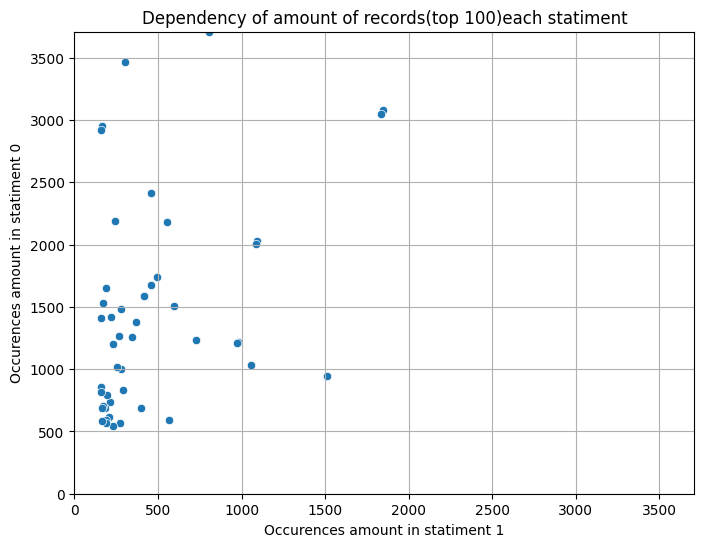

In [30]:
#one of the natural things to do is to check coorelation between sentiment 0 and sentiment 1 among most popular

positivity_100=  pd.DataFrame({'bigrams': postivive_collocations_dict[:100].index.to_list(), 'amount': postivive_collocations_dict[:100]['amount']})
positivity_100.reset_index(drop=True, inplace=True)

negativity_100=  pd.DataFrame({'bigrams': negative_collocations_dict[:100].index.to_list(), 'amount': negative_collocations_dict[:100]['amount']})
negativity_100.reset_index(drop=True, inplace=True)

#consider only bigrams appearing in both groups

positivity_100= positivity_100[positivity_100['bigrams'].isin(negativity_100['bigrams'])]
negativity_100= negativity_100[negativity_100['bigrams'].isin(positivity_100['bigrams'])]

connected_pos_neg = positivity_100.merge(negativity_100, on='bigrams', suffixes=('_df1', '_df2'), how='outer')

plt.figure(figsize=(8, 6))
sns.scatterplot(x='amount_df1', y='amount_df2', data=connected_pos_neg)

x_max = connected_pos_neg['amount_df1'].max()
y_max = connected_pos_neg['amount_df2'].max()

max_val = max(x_max, y_max)
plt.xlim(0, max_val)
plt.ylim(0, max_val)

plt.title('Dependency of amount of records(top 100)each statiment')
plt.xlabel('Occurences amount in statiment 1')
plt.ylabel('Occurences amount in statiment 0')
plt.grid(True)
plt.show()

In [31]:
positivity_full=  pd.DataFrame({'bigrams': postivive_collocations_dict.index.to_list(), 'amount': postivive_collocations_dict['amount']})
positivity_full.reset_index(drop=True, inplace=True)

negativity_full=  pd.DataFrame({'bigrams': negative_collocations_dict.index.to_list(), 'amount': negative_collocations_dict['amount']})
negativity_full.reset_index(drop=True, inplace=True)

c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

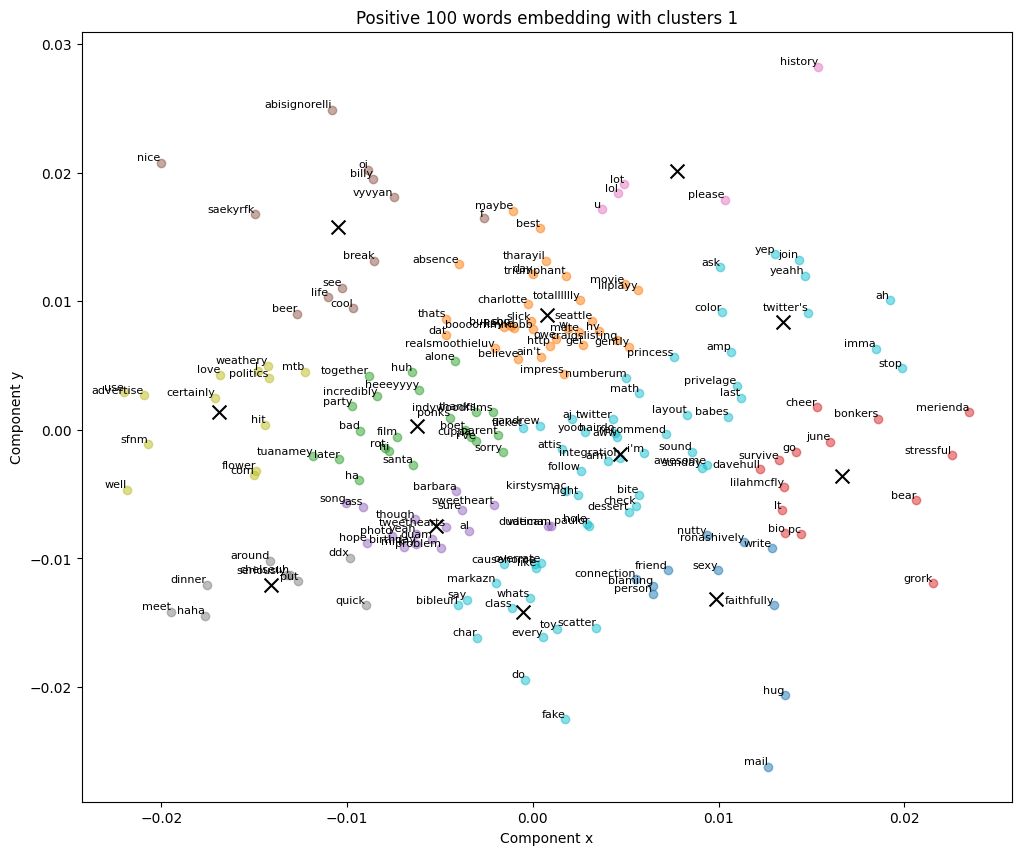

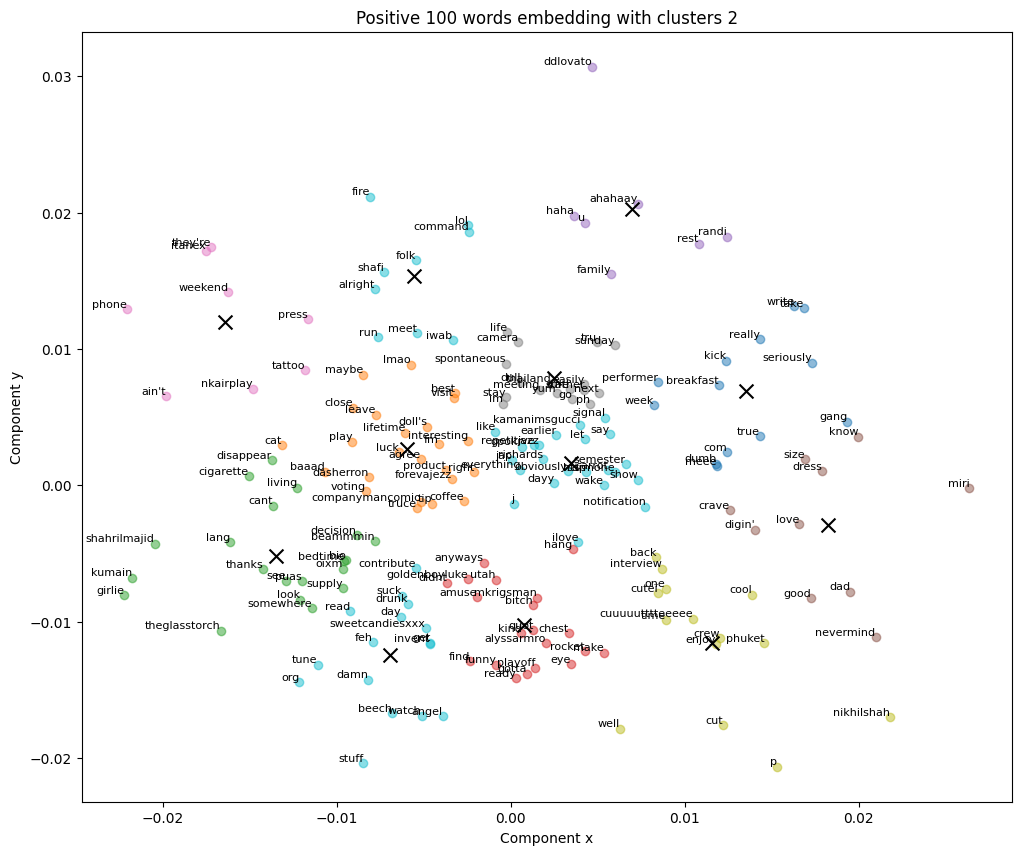

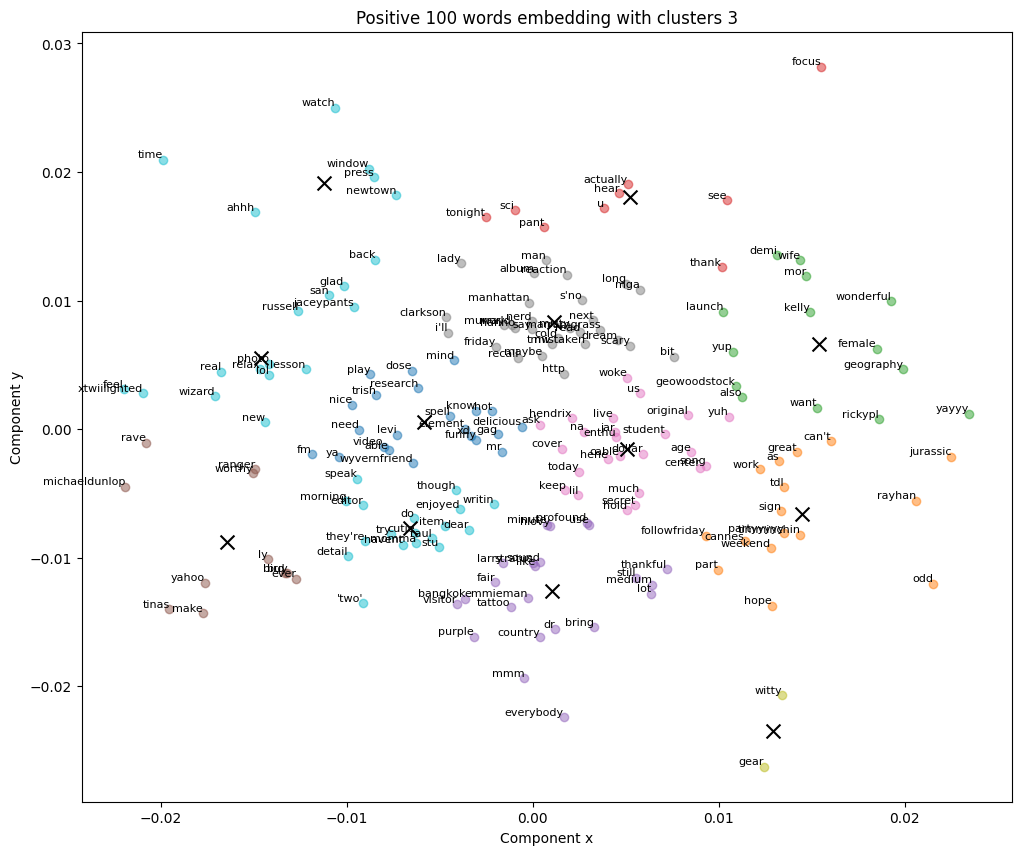

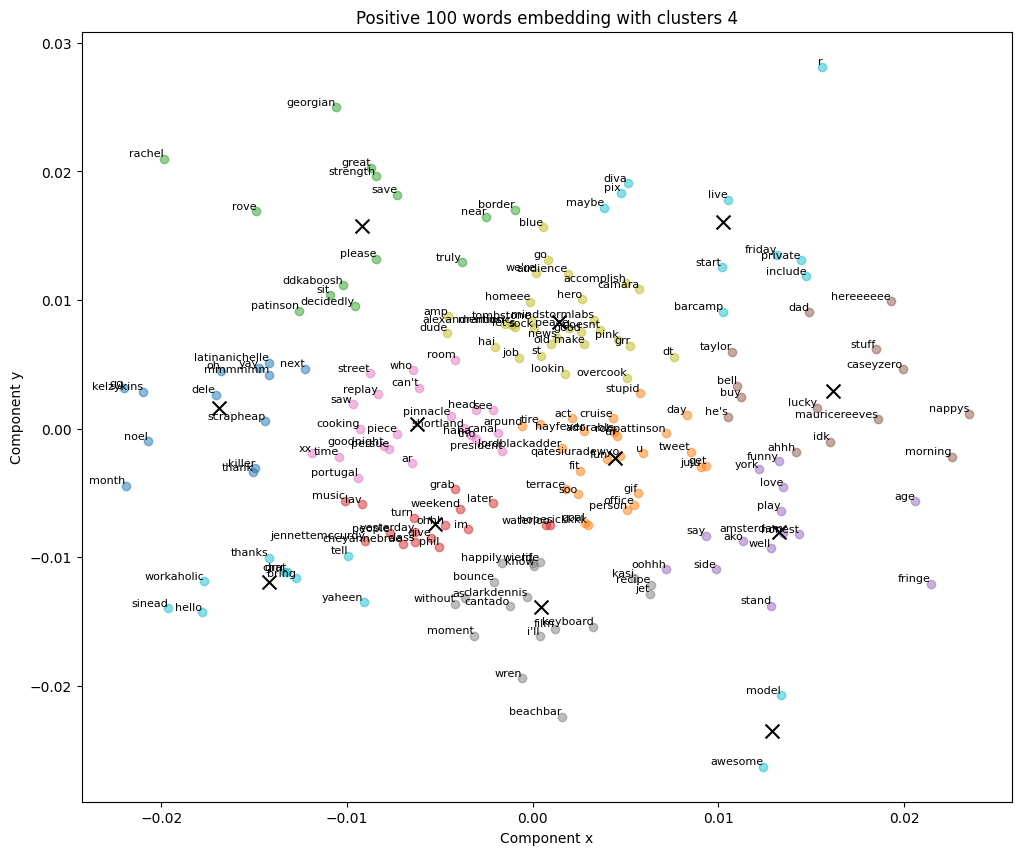

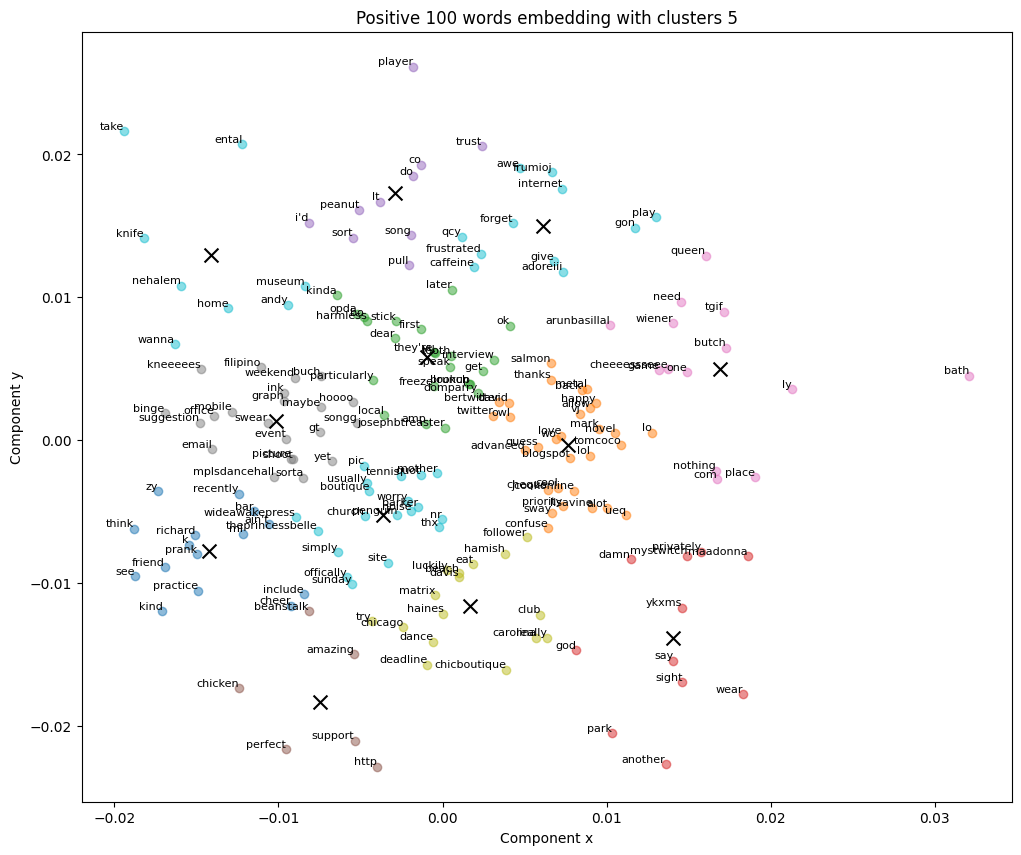

In [32]:
#words embedding

#how is words embedding different then graph representation and what other insights can it give us
#graph representation tells us about connections but due to "not keeping distance" it is rather hard to group those bigrams
#so we used graph to see something compared to distribution or domination of some records.
#in this embedding we rather focus on how the distance affects the thematic grouping of bigrams
#however we have to be careful, this is not equivalent to topic modelling


from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

samples = [random.choices(positivity_full['bigrams'], k=100) for _ in range(5)]

model = Word2Vec(samples[0], vector_size=100, window=5, min_count=1, sg=0)
model1= Word2Vec(samples[1], vector_size=100, window=5, min_count=1, sg=0)
model2= Word2Vec(samples[2], vector_size=100, window=5, min_count=1, sg=0)
model3= Word2Vec(samples[3], vector_size=100, window=5, min_count=1, sg=0)
model4= Word2Vec(samples[4], vector_size=100, window=5, min_count=1, sg=0)

# dimenstion reduction with PCA
def reduce_dimensions(word_vectors):
    pca = PCA(n_components=2)
    pca.fit(word_vectors)
    return pca.transform(word_vectors)

word_vectors = model.wv[model.wv.key_to_index]
word_vectors1= model1.wv[model1.wv.key_to_index]
word_vectors2= model2.wv[model2.wv.key_to_index]
word_vectors3= model3.wv[model3.wv.key_to_index]
word_vectors4= model4.wv[model4.wv.key_to_index]

reduced_word_vectors = reduce_dimensions(word_vectors)
reduced_word_vectors_1 = reduce_dimensions(word_vectors1)
reduced_word_vectors_2 = reduce_dimensions(word_vectors2)
reduced_word_vectors_3 = reduce_dimensions(word_vectors3)
reduced_word_vectors_4 = reduce_dimensions(word_vectors4)

def cluster_embeddings(word_vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(word_vectors)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return labels, centroids

num_clusters = 12

labels, centroids = cluster_embeddings(reduced_word_vectors, num_clusters)
labels1, centroids1= cluster_embeddings(reduced_word_vectors_1, num_clusters)
labels2, centroids2= cluster_embeddings(reduced_word_vectors_2, num_clusters)
labels3, centroids3= cluster_embeddings(reduced_word_vectors_3, num_clusters)
labels4, centroids4= cluster_embeddings(reduced_word_vectors_4, num_clusters)

def plot_embeddings_with_clusters(word_vectors, words, labels, centroids, which):
    plt.figure(figsize=(12, 10))
    for i in range(len(labels)):
        plt.scatter(word_vectors[i, 0], word_vectors[i, 1], color=plt.cm.tab10(labels[i]), alpha=0.5)
        plt.text(word_vectors[i, 0], word_vectors[i, 1], words[i], fontsize=8, ha='right', va='bottom')
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', color='black', s=100)
    plt.xlabel('Component x')
    plt.ylabel('Component y')
    plt.title('Positive 100 words embedding with clusters '+ str(which))
    plt.show()

plot_embeddings_with_clusters(reduced_word_vectors, model.wv.index_to_key, labels, centroids, 1)
plot_embeddings_with_clusters(reduced_word_vectors_1, model1.wv.index_to_key, labels1, centroids1, 2)
plot_embeddings_with_clusters(reduced_word_vectors_2, model2.wv.index_to_key, labels2, centroids2, 3)
plot_embeddings_with_clusters(reduced_word_vectors_3, model3.wv.index_to_key, labels3, centroids3, 4)
plot_embeddings_with_clusters(reduced_word_vectors_4, model4.wv.index_to_key, labels4, centroids4, 5)

c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program Files\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

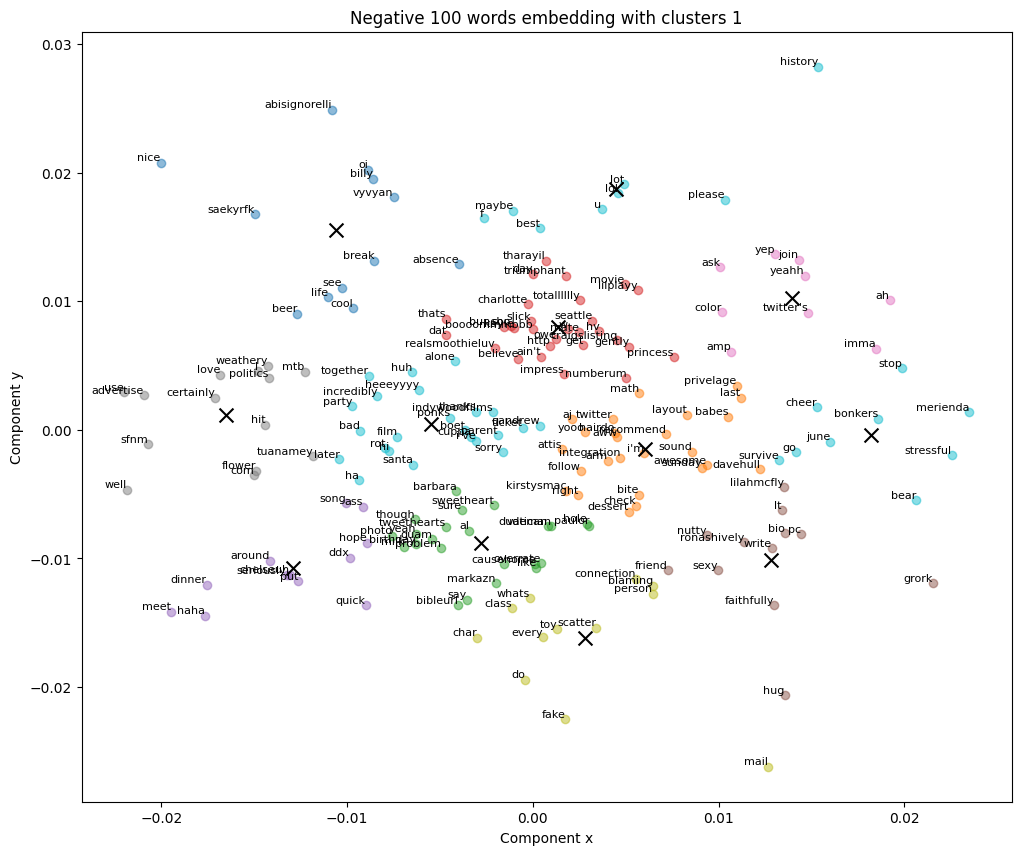

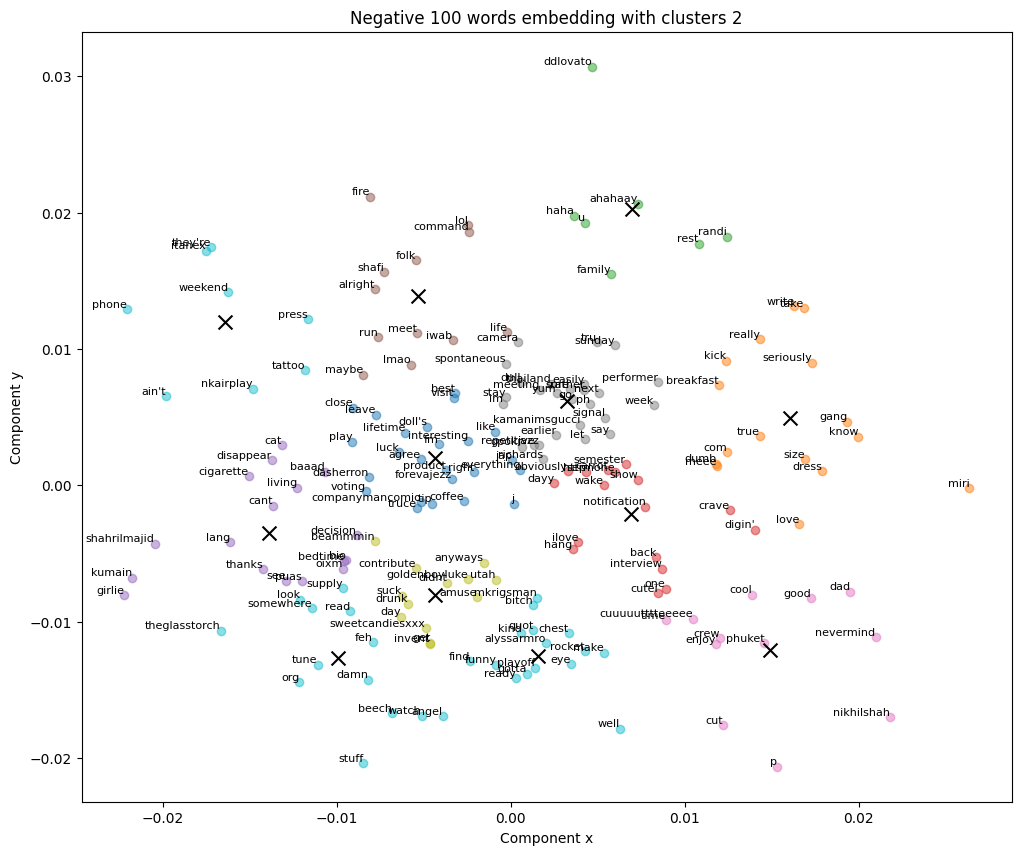

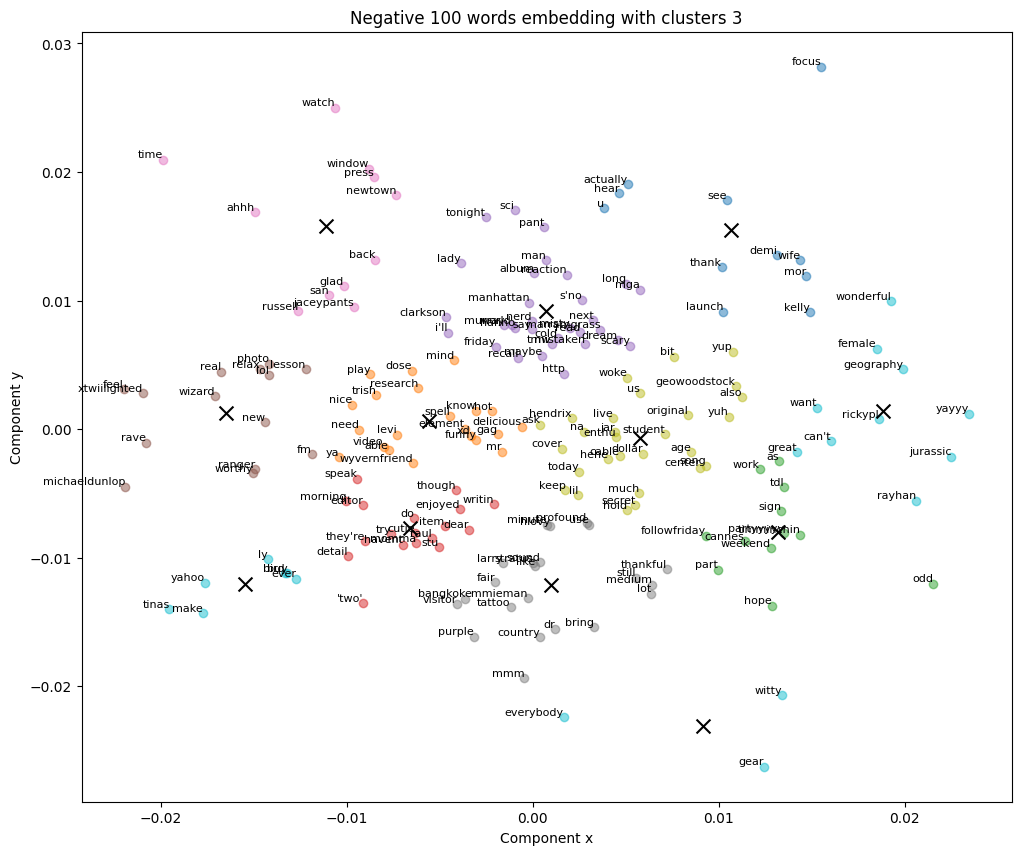

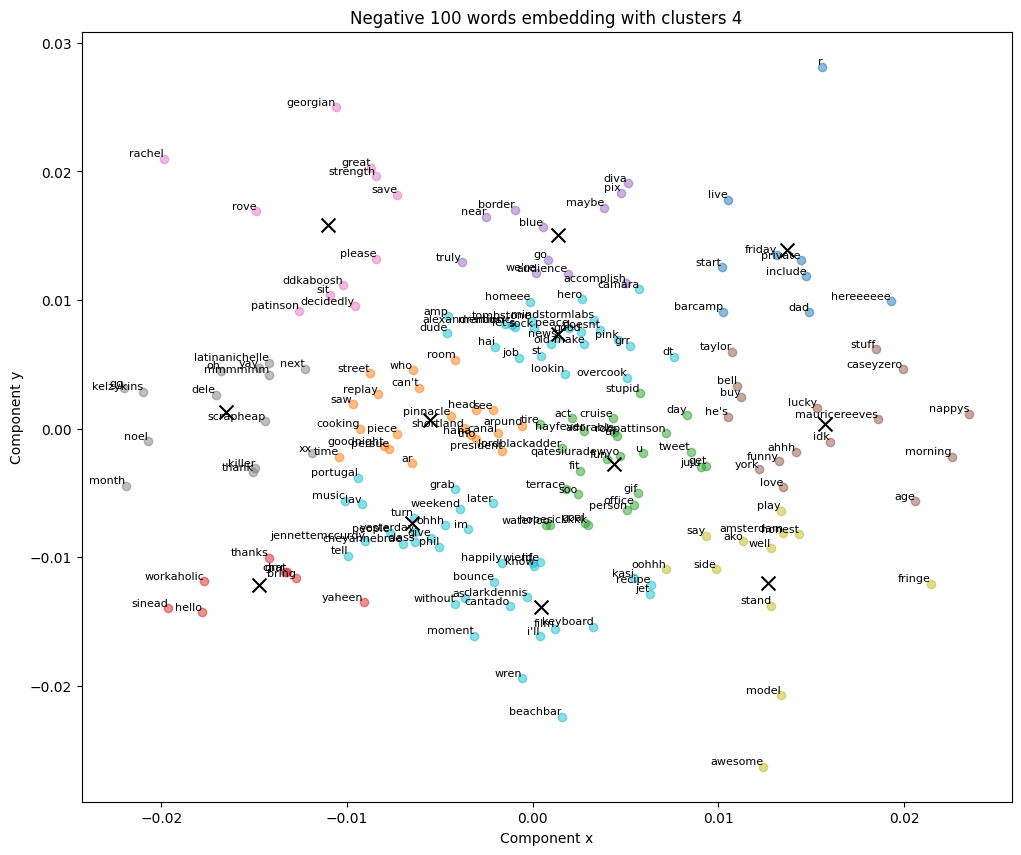

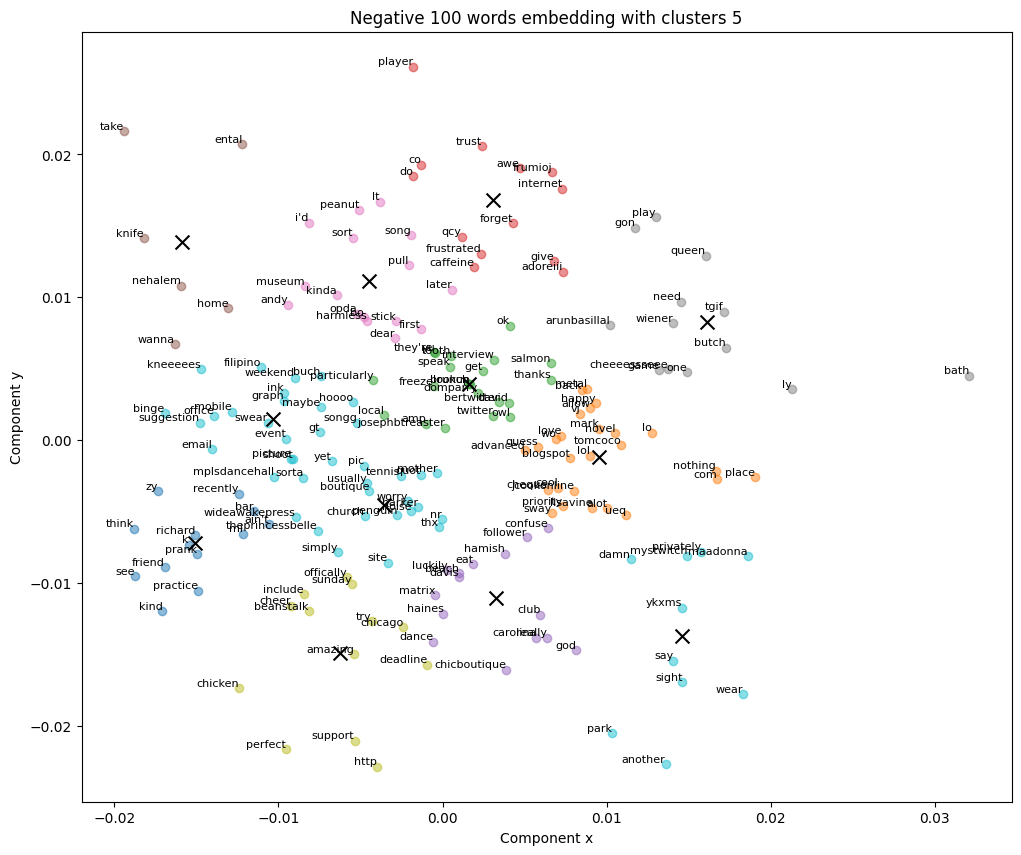

In [33]:
#the same goes for negatives, a code redundation is a problem here

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

negative_samples = [random.choices(negativity_full['bigrams'], k=100) for _ in range(5)]

models_list= [Word2Vec(samples[i], vector_size=100, window=5, min_count=1, sg=0) for i in range(5)]

# dimenstion reduction with PCA
def reduce_dimensions(word_vectors):
    pca = PCA(n_components=2)
    pca.fit(word_vectors)
    return pca.transform(word_vectors)


reduces_word_vectors_list= [0, 0, 0, 0, 0]

for i in range(5):
    reduces_word_vectors_list[i]= reduce_dimensions(models_list[i].wv[models_list[i].wv.key_to_index])

def cluster_embeddings(word_vectors, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(word_vectors)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return labels, centroids

num_clusters = 12

labels= []
centroids= []

for i in range(5):
    l, c= cluster_embeddings(reduces_word_vectors_list[i], num_clusters)
    labels.append(l)
    centroids.append(c)

def plot_embeddings_with_clusters(word_vectors, words, labels, centroids, which):
    plt.figure(figsize=(12, 10))
    for i in range(len(labels)):
        plt.scatter(word_vectors[i, 0], word_vectors[i, 1], color=plt.cm.tab10(labels[i]), alpha=0.5)
        plt.text(word_vectors[i, 0], word_vectors[i, 1], words[i], fontsize=8, ha='right', va='bottom')
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', color='black', s=100)
    plt.xlabel('Component x')
    plt.ylabel('Component y')
    plt.title('Negative 100 words embedding with clusters '+ str(which))
    plt.show()

for i in range(5):
    plot_embeddings_with_clusters(reduces_word_vectors_list[i], models_list[i].wv.index_to_key, labels[i], centroids[i], i+1)

### Topics and their statiments analysis

In [145]:
#based on: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ (that is the source i used to possess knowledge)

#we are going to use technique: NLP topic modelling rather then NLP topic classification as the first one doesn't require train data(unsupervised ML technique, drawbacks: can be inaccurate)

#Aspect-Based Sentiment Analysis

#topic modelling ways: LSA-Latent Semantic Analysis, LDA- Latent Dirichlet Allocation in our analysis we will only focus on LDA

#random records

positive_tweets = tweets_df[tweets_df['Target'] == 1]

num_positive_tweets = positive_tweets.shape[0]

if num_positive_tweets >= 500000:
    sampled_positive_tweets = positive_tweets.sample(n=500000, random_state=1)  # Ustaw random_state dla powtarzalności
else:
    sampled_positive_tweets = positive_tweets

words_positive = sampled_positive_tweets['lemmatized_tokens'].tolist()

dictionary = corpora.Dictionary(words_positve)

corpus = [dictionary.doc2bow(text) for text in words_positve]

# amount of topics to model
num_topics = 35

# LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30, minimum_probability=0.01)

#coherence score will tell us how good the words fit together to the group they belong to
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_positve, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score (LDA): {coherence_lda}')

# printing from topic 1
for i, topic in enumerate(lda_model.print_topics()):
    print(f'Topic: {i+1} \nWords: {topic[1]}\n')


Coherence Score (LDA): 0.42082118832106746
Topic: 1 
Words: 0.017*"get" + 0.014*"love" + 0.012*"thank" + 0.012*"oh" + 0.009*"read" + 0.009*"im" + 0.009*"u" + 0.009*"good" + 0.009*"think" + 0.009*"idea"

Topic: 2 
Words: 0.011*"i'm" + 0.011*"like" + 0.011*"color" + 0.010*"go" + 0.008*"quot" + 0.008*"two" + 0.008*"day" + 0.008*"time" + 0.008*"next" + 0.008*"week"

Topic: 3 
Words: 0.024*"good" + 0.015*"back" + 0.013*"today" + 0.010*"quot" + 0.010*"time" + 0.010*"weekend" + 0.008*"day" + 0.008*"start" + 0.008*"amp" + 0.008*"see"

Topic: 4 
Words: 0.013*"quot" + 0.010*"get" + 0.010*"today" + 0.010*"go" + 0.010*"good" + 0.010*"little" + 0.007*"bit" + 0.007*"mean" + 0.007*"see" + 0.007*"tour"

Topic: 5 
Words: 0.016*"go" + 0.013*"really" + 0.008*"look" + 0.008*"time" + 0.008*"can't" + 0.008*"back" + 0.008*"lol" + 0.008*"see" + 0.008*"great" + 0.008*"night"

Topic: 6 
Words: 0.027*"get" + 0.017*"go" + 0.014*"today" + 0.014*"white" + 0.014*"good" + 0.010*"one" + 0.010*"i'm" + 0.010*"bit" + 0.0

In [ ]:
#quick analysis as we may see the coherence score is not too big for given topics amount(the words do not fit very well to each other), that's the reason
#we will try to use maximize the coherence value by trying different num_topics(find the maximum of one value)

In [138]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
   
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):

        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30, minimum_probability=0.01)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=words_positve, start=2, limit=200, step=6)

x = range(2, 200, 6)

coherence_frame= pd.DataFrame({"Num Topics": range(2,200, 6), "Coherence score": coherence_values})

sns.lineplot(data= coherence_frame, x="Num Topics", y="Coherence score")
plt.legend(labels= ['coherence dependency'])
plt.show()

KeyboardInterrupt: 

In [66]:
#now it is time to visualize topic modelling some effects(setting 35 topics for more readibly)
#we will use one of the best tools for that

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='tsne', R=100)
vis

C:\Users\igorr\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
33    -5.850554  7.608958       1        1  4.352576
19    -6.544687  7.593910       2        1  4.225071
22    -4.786383  8.170115       3        1  4.219695
23    -5.852085  7.575793       4        1  3.424865
14    -5.582847  8.260098       5        1  3.364480
32    -5.089463  7.784456       6        1  3.323639
0     -5.453230  8.729607       7        1  3.251121
6     -6.406178  9.178853       8        1  3.248302
18    -5.523081  8.713520       9        1  3.193173
8     -5.616619  7.545820      10        1  3.164549
12    -6.033521  8.113669      11        1  3.054215
31    -6.301479  8.396145      12        1  3.015360
5     -5.273604  8.556227      13        1  2.976162
9     -5.568443  8.135270      14        1  2.973313
13    -5.496104  8.682667      15        1  2.923830
1     -6.393627  8.586964      16        1  2.839181
34    -5.537113  7.821884      17        1  2.838341
25    -5.900113  8.608124      18        1  2.826780
20    -4.993339  8.257677      19        1  2.803339
10    -6.212475  7.934432      20        1  2.764403
11    -5.427126  7.912903      21        1  2.694345
24    -5.512427  8.174234      22        1  2.691162
28    -5.733054  8.079826      23        1  2.625148
16    -5.656870  8.158946      24        1  2.623640
30    -6.010288  7.921775      25        1  2.510714
2     -5.340678  8.128140      26        1  2.400257
21    -6.292537  8.280820      27        1  2.388848
17    -5.748656  8.653680      28        1  2.358065
7     -5.848412  8.389215      29        1  2.348636
15    -6.065381  8.279384      30        1  2.315010
3     -5.690938  8.244043      31        1  2.262199
26    -6.112854  8.216373      32        1  2.179864
27    -5.767592  8.118169      33        1  2.112555
29    -6.089812  8.272736      34        1  2.034371
4     -5.808791  8.297285      35        1  1.672790, topic_info=             Term       Freq      Total Category   logprob   loglift
39            com  40.000000  40.000000  Default  100.0000  100.0000
15           http  51.000000  51.000000  Default   99.0000   99.0000
2106            ï  19.000000  19.000000  Default   98.0000   98.0000
470          quot  41.000000  41.000000  Default   97.0000   97.0000
207           day  57.000000  57.000000  Default   96.0000   96.0000
172           get  69.000000  69.000000  Default   95.0000   95.0000
61        twitpic  17.000000  17.000000  Default   94.0000   94.0000
17           good  58.000000  58.000000  Default   93.0000   93.0000
4           happy  25.000000  25.000000  Default   92.0000   92.0000
98            i'm  52.000000  52.000000  Default   91.0000   91.0000
...           ...        ...        ...      ...       ...       ...
385         great   0.639496  25.330440  Topic35   -5.3601    0.4116
495   gratulation   0.017765   0.705521  Topic35   -8.9436    0.4089
496          zehn   0.017765   0.705521  Topic35   -8.9436    0.4089
15           http   1.261266  51.010887  Topic35   -4.6809    0.3908
401          make   0.639496  26.993113  Topic35   -5.3601    0.3480
86             go   0.639497  58.467909  Topic35   -5.3601   -0.4249
104          love   0.639497  52.287942  Topic35   -5.3601   -0.3132
73          think   0.639496  32.715408  Topic35   -5.3601    0.1558
9            work   0.639496  30.048790  Topic35   -5.3601    0.2408
172           get   0.639495  69.454686  Topic35   -5.3601   -0.5971

[5377 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
765       3  0.547345             '
765      11  0.273673             '
765      19  0.273673             '
2671      2  0.680458  'accounting'
615      12  0.702890        'block
2517     32  0.727355       'buffy'
2338      1  0.677186         'did'
1724      1  0.677180         'even
2518     32  0.727355          'fx'
1377     12  0.702887         'good
...     

### Adding columns with positivity/negativity/neutral etc

In [36]:
# one may need to install !pip install afinn


# Initialization
afinn = Afinn()
sia = SentimentIntensityAnalyzer()

def calculate_sentiments(text):
    # Using TextBlob
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    # Using VADER
    vader_scores = sia.polarity_scores(text)

    # Using AFINN
    afinn_score = afinn.score(text)

    return {
        'polarity': polarity,
        'subjectivity': subjectivity,
        'negative': vader_scores['neg'],
        'neutral': vader_scores['neu'],
        'positive': vader_scores['pos'],
        'compound': vader_scores['compound'],
        'afinn_score': afinn_score,
    }

# Applying the function to each row in the DataFrame
tweets_df['sentiments'] = tweets_df['Text'].apply(calculate_sentiments)
tweets_df = pd.concat([tweets_df.drop(['sentiments'], axis=1), tweets_df['sentiments'].apply(pd.Series)], axis=1)

In [38]:
tweets_df

Target                                               Text                                             tokens                                               tags                                  lemmatized_tokens  words_counted                                       collocations  polarity  subjectivity  negative  neutral  positive  compound  afinn_score
810677        1  working  listening to KMPS  happy my boss  amp...  [working, listening, kmps, happy, boss, amp, m...  [(working, VBG), (listening, VBG), (kmps, NNS)...  [work, listen, kmps, happy, boss, amp, mechani...             10  [(work, listen), (listen, kmps), (kmps, happy)...  0.800000      1.000000     0.000    0.670     0.330    0.7845          5.0
684982        0    We both know she is late for  quot at    quot                             [know, late, quot, quot]  [(know, VB), (late, JJ), (quot, NNS), (quot, NN)]                           [know, late, quot, quot]              4         [(know, late), (late, quot), (quot, quot)] -0.300000      0.600000     0.000    1.000     0.000    0.0000          0.0
954730        1  don't bogart that joint my friend    http   bl...        [bogart, joint, friend, http, blip, fm, gg]  [(bogart, RB), (joint, JJ), (friend, NN), (htt...        [bogart, joint, friend, http, blip, fm, gg]              7  [(bogart, joint), (joint, friend), (friend, ht...  0.000000      0.000000     0.000    0.625     0.375    0.6597          1.0
142760        0  I'm so sick of being sick  I don't want to mis...     [i'm, sick, sick, want, miss, another, summer]  [(i'm, NN), (sick, JJ), (sick, NN), (want, VBP...     [i'm, sick, sick, want, miss, another, summer]              7  [(i'm, sick), (sick, sick), (sick, want), (wan... -0.714286      0.857143     0.437    0.485     0.078   -0.7698         -5.0
200331        0  im pretty sure i went to bed about      hours ...  [im, pretty, sure, went, bed, hours, ago, im, ...  [(im, NN), (pretty, RB), (sure, JJ), (went, VB...   [im, pretty, sure, go, bed, hour, ago, im, ahhh]              9  [(im, pretty), (pretty, sure), (sure, go), (go...  0.375000      0.944444     0.000    0.703     0.297    0.6705          1.0
315291        0   Tamm Ah that's such a shame  Always sad to se...        [tamm, ah, that's, shame, always, sad, see]  [(tamm, NN), (ah, NN), (that's, NN), (shame, N...        [tamm, ah, that's, shame, always, sad, see]              7  [(tamm, ah), (ah, that's), (that's, shame), (s... -0.250000      0.750000     0.408    0.592     0.000   -0.7351         -4.0
782419        0   plans didn't come threw again  what does it t...  [plans, come, threw, take, good, exciting, day...  [(plans, NNS), (come, VBP), (threw, NNS), (tak...  [plan, come, threw, take, good, exciting, day,...             10  [(plan, come), (come, threw), (threw, take), (...  0.500000      0.700000     0.000    0.757     0.243    0.7269          6.0
808655        1                         good morning  twitterbugs                        [good, morning, twitterbugs]    [(good, JJ), (morning, NN), (twitterbugs, NNS)]                       [good, morning, twitterbugs]              3          [(good, morning), (morning, twitterbugs)]  0.700000      0.600000     0.000    0.408     0.592    0.4404          3.0
919558        1                         scouserach Not today Rach                           [scouserach, today, rach]       [(scouserach, NN), (today, NN), (rach, VBP)]                          [scouserach, today, rach]              3               [(scouserach, today), (today, rach)]  0.000000      0.000000     0.000    1.000     0.000    0.0000          0.0
681356        0                                i has the sniffles                                          [sniffles]                                  [(sniffles, NNS)]                                          [sniffle]              1                                                 []  0.000000      0.000000     0.000    1.000     0.000    0.0000          0.0
...         ...            

### Adding columns with information whether the 'text' is complex and if it contains negation

In [39]:
#one may have to install this
#!pip install spacy
#!python -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm')

# function to text analysis
def analyze_text(text):
    # text analysis using Spacy
    doc = nlp(text)
    
    # sentences analysis
    sentences = list(doc.sents)
    is_complex = len(sentences) > 1  # True, jeśli mamy więcej niż jedno zdanie
    
    # looking for negations
    has_negation = any(token.dep_ == 'neg' for token in doc)
    
    return {'complex': is_complex, 'negation': has_negation}



tweets_df[['complex', 'negation']] = tweets_df['Text'].apply(lambda text: pd.Series(analyze_text(text)))
tweets_df['complex'] = tweets_df['complex'].astype(int)
tweets_df['negation'] = tweets_df['negation'].astype(int)
tweets_df[['Text', 'complex', 'negation']].head()

Text  complex  negation
810677  working  listening to KMPS  happy my boss  amp...        0         0
684982    We both know she is late for  quot at    quot          0         0
954730  don't bogart that joint my friend    http   bl...        0         1
142760  I'm so sick of being sick  I don't want to mis...        0         1
200331  im pretty sure i went to bed about      hours ...        0         0

### Adding columns with month, day and hour 

In [40]:
tweets_df['Date']=tweets['Date']
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], errors='coerce')
tweets_df['Hour'] = tweets_df['Date'].dt.hour
tweets_df['DayOfWeek'] = tweets_df['Date'].dt.dayofweek
tweets_df['Month'] = tweets_df['Date'].dt.month

C:\Users\igorr\AppData\Roaming\Python\Python38\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


### Graphs connected with time and heatmap

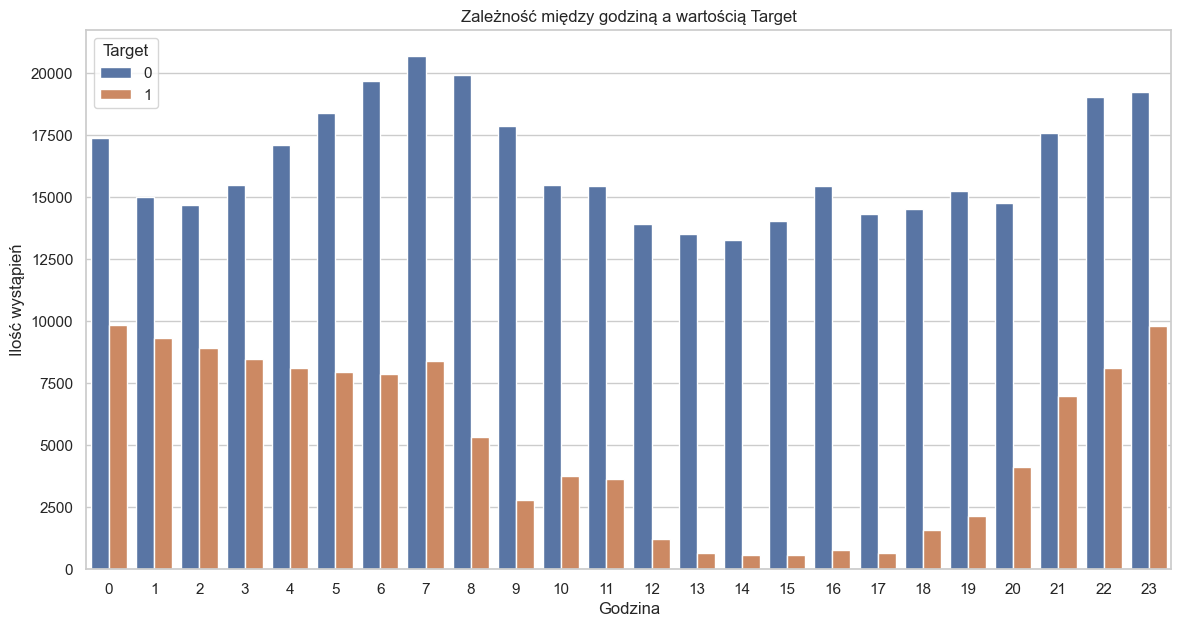

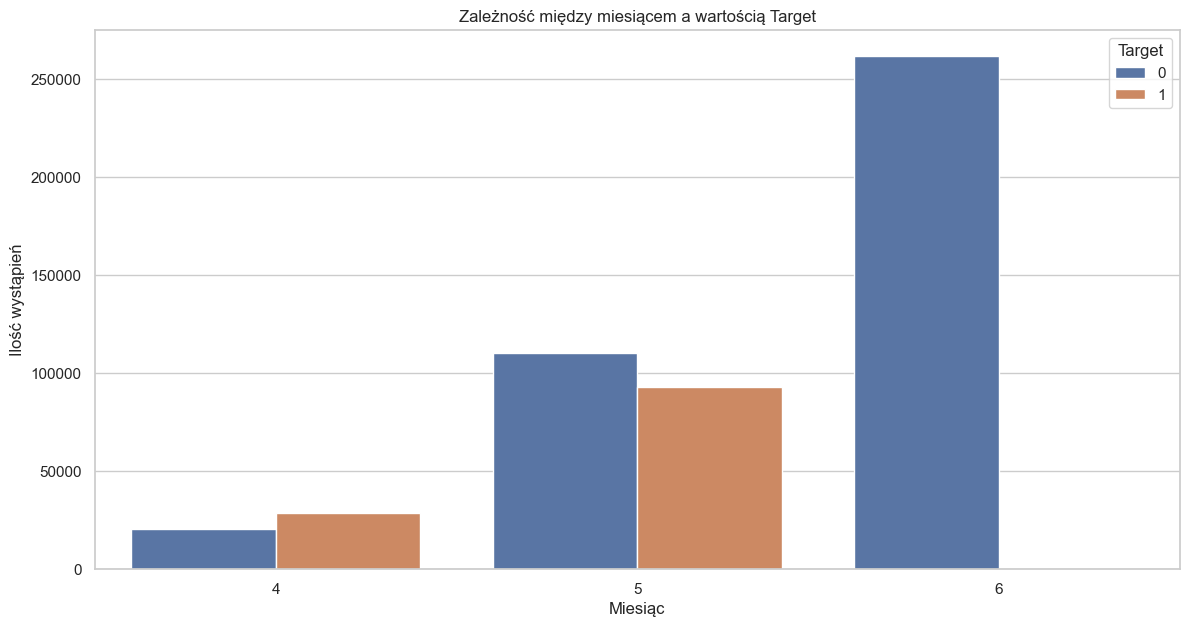

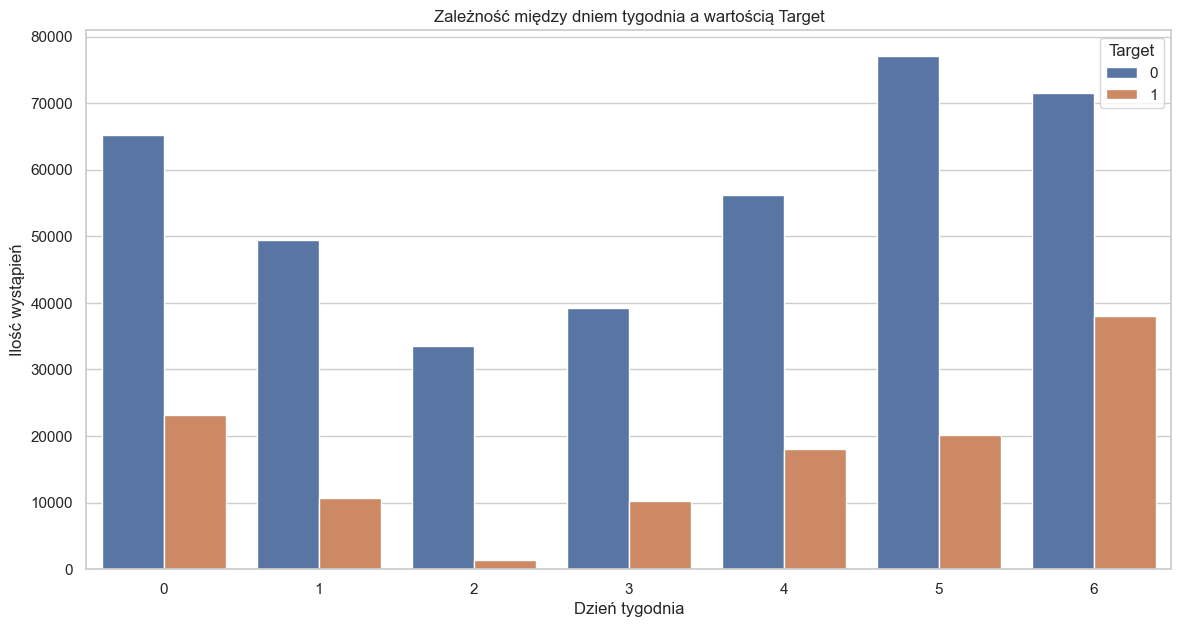

In [75]:
sns.set(style="whitegrid")

# Graph 'Hour' and 'Target'
plt.figure(figsize=(14, 7))
sns.countplot(x='Hour', hue='Target', data=tweets_df)
plt.title('Zależność między godziną a wartością Target')
plt.xlabel('Godzina')
plt.ylabel('Ilość wystąpień')
plt.show()

# Graph 'Month' and 'Target'
plt.figure(figsize=(14, 7))
sns.countplot(x='Month', hue='Target', data=tweets_df)
plt.title('Zależność między miesiącem a wartością Target')
plt.xlabel('Miesiąc')
plt.ylabel('Ilość wystąpień')
plt.show()

# Graph 'DayOfWeek' and 'Target'
plt.figure(figsize=(14, 7))
sns.countplot(x='DayOfWeek', hue='Target', data=tweets_df)
plt.title('Zależność między dniem tygodnia a wartością Target')
plt.xlabel('Dzień tygodnia')
plt.ylabel('Ilość wystąpień')
plt.show()

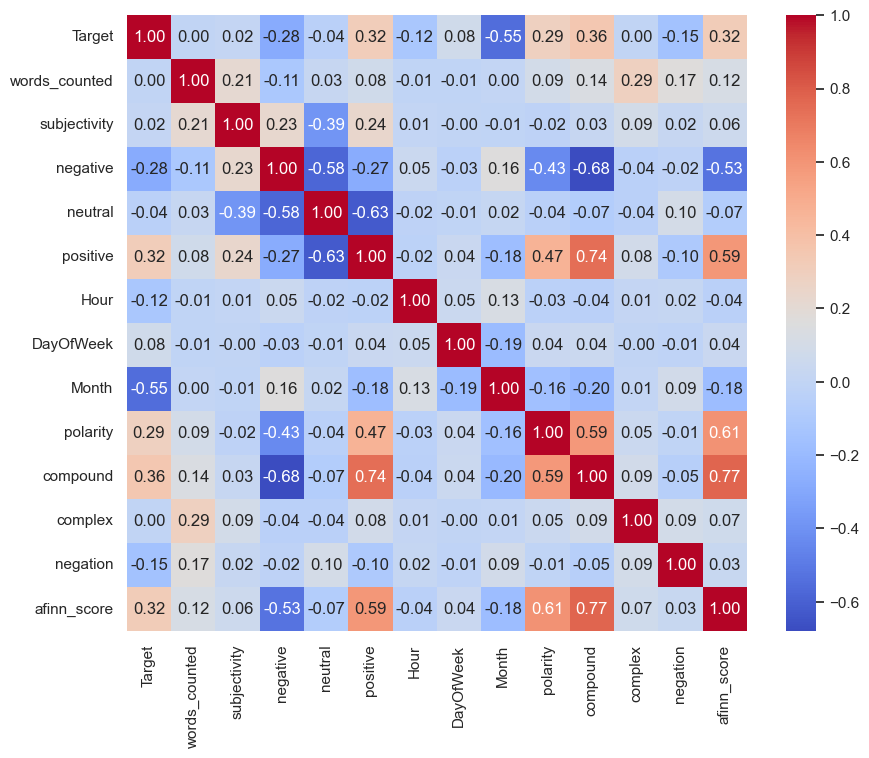

In [76]:
# Assuming tweets_df is your dataframe
correlation_matrix = tweets_df[['Target', 'words_counted', 'subjectivity', 
                                'negative', 'neutral', 'positive', 
                                'Hour', 'DayOfWeek', 'Month','polarity','compound','complex','negation','afinn_score']].corr()

# Using seaborn to create a heatmap with the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Emotion analysis

In [41]:
# one may need to install: !pip install nrclex

# Define the function to extract emotions
def extract_emotions_nrc(text):
    # Create an NRCLex object
    emotion_analysis = NRCLex(text)

    # Define the 8 basic emotions we're interested in
    emotions = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'joy', 'disgust']

    # Extract the frequencies of these emotions from the text
    emotion_frequencies = {emotion: emotion_analysis.affect_frequencies.get(emotion, 0) for emotion in emotions}

    # Convert the dictionary to a pandas Series and return it
    return pd.Series(emotion_frequencies)

emotions = ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'joy', 'disgust']
# Assuming 'tweets_df' has a column named 'Text' containing the text to analyze
# Apply the 'extract_emotions_nrc' function to each row in the 'Text' column and add the results as new columns
tweets_df[emotions] = tweets_df['Text'].apply(extract_emotions_nrc)

# Print the DataFrame with the new emotion columns
tweets_df.head(10)

Target                                               Text                                             tokens                                               tags                                  lemmatized_tokens  words_counted                                       collocations  polarity  subjectivity  negative  neutral  positive  compound  afinn_score  complex  negation                Date  Hour  DayOfWeek  Month  fear  anger  anticipation     trust  surprise   sadness       joy   disgust
810677       1  working  listening to KMPS  happy my boss  amp...  [working, listening, kmps, happy, boss, amp, m...  [(working, VBG), (listening, VBG), (kmps, NNS)...  [work, listen, kmps, happy, boss, amp, mechani...             10  [(work, listen), (listen, kmps), (kmps, happy)...  0.800000      1.000000     0.000    0.670     0.330    0.7845          5.0        0         0 2009-04-07 07:35:21     7          1      4  0.00    0.0      0.200000  0.200000  0.000000  0.000000  0.200000  0.000000
684982       0    We both know she is late for  quot at    quot                             [know, late, quot, quot]  [(know, VB), (late, JJ), (quot, NNS), (quot, NN)]                           [know, late, quot, quot]              4         [(know, late), (late, quot), (quot, quot)] -0.300000      0.600000     0.000    1.000     0.000    0.0000          0.0        0         0 2009-06-20 01:07:37     1          5      6  0.00    0.0      0.000000  0.000000  0.000000  0.500000  0.000000  0.000000
954730       1  don't bogart that joint my friend    http   bl...        [bogart, joint, friend, http, blip, fm, gg]  [(bogart, RB), (joint, JJ), (friend, NN), (htt...        [bogart, joint, friend, http, blip, fm, gg]              7  [(bogart, joint), (joint, friend), (friend, ht...  0.000000      0.000000     0.000    0.625     0.375    0.6597          1.0        0         1 2009-05-17 03:26:07     3          6      5  0.00    0.0      0.000000  0.333333  0.000000  0.000000  0.333333  0.000000
142760       0  I'm so sick of being sick  I don't want to mis...     [i'm, sick, sick, want, miss, another, summer]  [(i'm, NN), (sick, JJ), (sick, NN), (want, VBP...     [i'm, sick, sick, want, miss, another, summer]              7  [(i'm, sick), (sick, sick), (sick, want), (wan... -0.714286      0.857143     0.437    0.485     0.078   -0.7698         -5.0        0         1 2009-05-22 04:58:33     4          4      5  0.00    0.0      0.000000  0.000000  0.000000  0.333333  0.000000  0.333333
200331       0  im pretty sure i went to bed about      hours ...  [im, pretty, sure, went, bed, hours, ago, im, ...  [(im, NN), (pretty, RB), (sure, JJ), (went, VB...   [im, pretty, sure, go, bed, hour, ago, im, ahhh]              9  [(im, pretty), (pretty, sure), (sure, go), (go...  0.375000      0.944444     0.000    0.703     0.297    0.6705          1.0        0         0 2009-05-30 07:34:01     7          5      5  0.00    0.0      0.250000  0.250000  0.000000  0.000000  0.250000  0.000000
315291       0   Tamm Ah that's such a shame  Always sad to se...        [tamm, ah, that's, shame, always, sad, see]  [(tamm, NN), (ah, NN), (that's, NN), (shame, N...        [tamm, ah, that's, shame, always, sad, see]              7  [(tamm, ah), (ah, that's), (that's, shame), (s... -0.250000      0.750000     0.408    0.592     0.000   -0.7351         -4.0        1         0 2009-06-02 03:21:23     3          1      6  0.25    0.0      0.000000  0.000000  0.000000  0.250000  0.000000  0.250000
782419       0   plans didn't come threw again  what does it t...  [plans, come, threw, take, good, exciting, day...  [(plans, NNS), (come, VBP), (threw, NNS), (tak...  [plan, come, threw, take, good, exciting, day,...             10  [(plan, come), (come, threw), (threw, take), (...  0.500000      0.700000     0.000    0.757     0.243    0.7269          6.0        1         1 2009-06-25 01:09:40     1          3      6  0.00    0.0      0.222222  0.111111  0.222222  0.000000  0.222222  0.000000


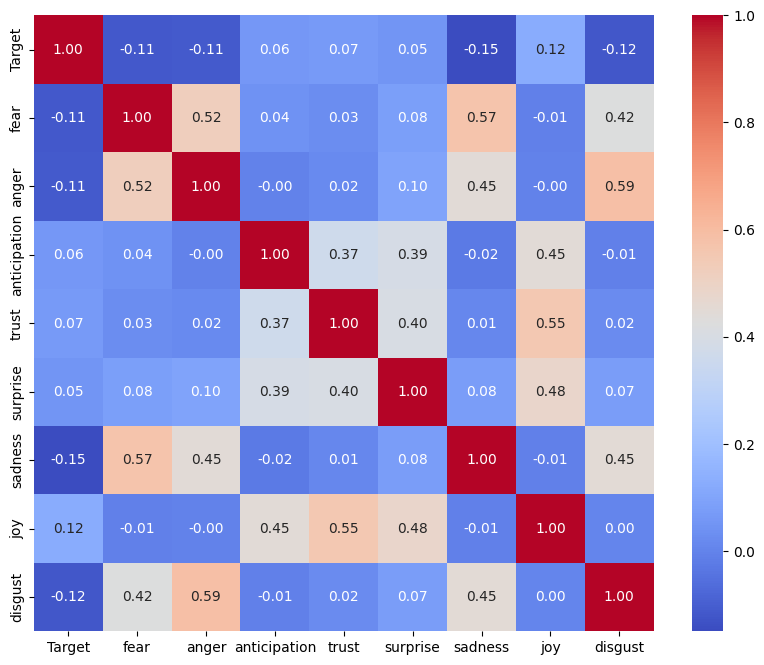

In [42]:
# Assuming tweets_df is your dataframe
correlation_matrix = tweets_df[['Target', 'fear', 'anger' , 'anticipation' , 'trust' , 'surprise' , 'sadness' , 'joy' , 'disgust']].corr(method='spearman')

# Using seaborn to create a heatmap with the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# Linguistic feature analysis

In [43]:
# Function to count exclamation marks in a text
def count_exclamation_marks(text):
    return text.count('!')

# Function to count question marks in a text
def count_question_marks(text):
    return text.count('?')

# Function to count words written in uppercase
def count_uppercase_words(text):
    return sum(word.isupper() for word in text.split())

# Function to count parts of speech
def count_parts_of_speech(tags_list):
    # Counts occurrences of each part-of-speech tag
    tag_counts = Counter(tag for _, tag in tags_list)
    return tag_counts

# Adding new columns to DataFrame
tweets_df['exclamation_count'] = tweets['Text'].apply(count_exclamation_marks)
tweets_df['question_count'] = tweets['Text'].apply(count_question_marks)
tweets_df['uppercase_count'] = tweets['Text'].apply(count_uppercase_words)

# If the 'tags' column contains strings formatted as tuples, we first process them
# Otherwise, we assume they are already tuples and use them directly
if isinstance(tweets_df['tags'].iloc[0], str):
    import ast
    tweets_df['tags'] = tweets_df['tags'].apply(ast.literal_eval)

# Creating a dictionary with the frequency of each part of speech for each entry
tweets_df['pos_counts'] = tweets_df['tags'].apply(count_parts_of_speech)

# Creating separate columns for each part of speech
pos_tags = set(tag for sublist in tweets_df['tags'].tolist() for _, tag in sublist)
for tag in pos_tags:
    tweets_df[f'count_{tag}'] = tweets_df['pos_counts'].apply(lambda x: x.get(tag, 0))

# Now tweets_df contains new columns with the requested information
tweets_df.head()  # Display the first few rows for confirmation

Target                                               Text                                             tokens                                               tags                                  lemmatized_tokens  words_counted                                       collocations  polarity  subjectivity  negative  neutral  positive  compound  afinn_score  complex  negation                Date  Hour  DayOfWeek  Month  fear  anger  anticipation     trust  surprise   sadness       joy   disgust  exclamation_count  question_count  uppercase_count                                         pos_counts  count_EX  count_RBS  count_PRP  count_RP  count_VBN  count_JJ  count_PDT  count_VB  count_IN  count_CC  count_WDT  count_NNS  count_NN  count_WRB  count_$  count_VBZ  count_WP$  count_JJR  count_CD  count_POS  count_TO  count_VBP  count_FW  count_NNPS  count_LS  count_''  count_JJS  count_RB  count_SYM  count_VBG  count_DT  count_WP  count_UH  count_MD  count_RBR  count_PRP$  count_NNP  \
810677       1  working  listening to KMPS  happy my boss  amp...  [working, listening, kmps, happy, boss, amp, m...  [(working, VBG), (listening, VBG), (kmps, NNS)...  [work, listen, kmps, happy, boss, amp, mechani...             10  [(work, listen), (listen, kmps), (kmps, happy)...  0.800000      1.000000     0.000    0.670     0.330    0.7845          5.0        0         0 2009-04-07 07:35:21     7          1      4   0.0    0.0          0.20  0.200000       0.0  0.000000  0.200000  0.000000                  0               0                1    {'VBG': 3, 'NNS': 1, 'JJ': 1, 'IN': 1, 'NN': 4}         0          0          0         0          0         1          0         0         1         0          0          1         4          0        0          0          0          0         0          0         0          0         0           0         0         0          0         0          0          3         0         0         0         0          0           0          0   
684982       0    We both know she is late for  quot at    quot                             [know, late, quot, quot]  [(know, VB), (late, JJ), (quot, NNS), (quot, NN)]                           [know, late, quot, quot]              4         [(know, late), (late, quot), (quot, quot)] -0.300000      0.600000     0.000    1.000     0.000    0.0000          0.0        0         0 2009-06-20 01:07:37     1          5      6   0.0    0.0          0.00  0.000000       0.0  0.500000  0.000000  0.000000                  0               0                0              {'VB': 1, 'JJ': 1, 'NNS': 1, 'NN': 1}         0          0          0         0          0         1          0         1         0         0          0          1         1          0        0          0          0          0         0          0         0          0         0           0         0         0          0         0          0          0         0         0         0         0          0           0          0   
954730       1  don't bogart that joint my friend    http   bl...        [bogart, joint, friend, http, blip, fm, gg]  [(bogart, RB), (joint, JJ), (friend, NN), (htt...        [bogart, joint, friend, http, blip, fm, gg]              7  [(bogart, joint), (joint, friend), (friend, ht...  0.000000      0.000000     0.000    0.625     0.375    0.6597          1.0        0         1 2009-05-17 03:26:07     3          6      5   0.0    0.0          0.00  0.333333       0.0  0.000000  0.333333  0.000000                  0               1                0                        {'RB': 1, 'JJ': 1, 'NN': 5}         0          0          0         0          0         1          0         0         0         0          0          0         5          0        0          0          0          0         0          0         0          0         0           0         0         0          0         1          0          0         0         0         0         0          0           0          0   
142760       0  I'm 

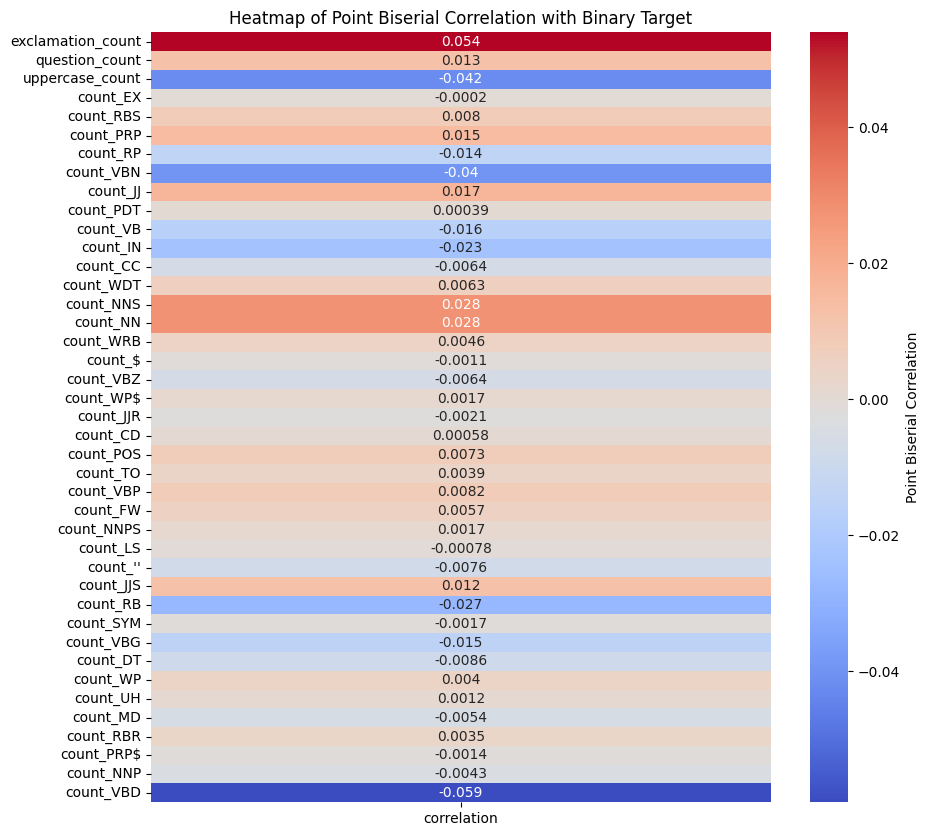

In [44]:
# Function to calculate point-biserial correlation
def calculate_pointbiserial(df, column):
    return pointbiserialr(df[column], df['Target']).correlation

# Creating a DataFrame to store correlation results
correlations = pd.DataFrame(index=['exclamation_count', 'question_count', 'uppercase_count'] + [f'count_{tag}' for tag in pos_tags])

# Calculating point-biserial correlation for each new column
correlations['correlation'] = correlations.index.map(lambda col: calculate_pointbiserial(tweets_df, col))

# Creating a heatmap of correlations
plt.figure(figsize=(10, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', cbar_kws={'label': 'Point Biserial Correlation'})
plt.title('Heatmap of Point Biserial Correlation with Binary Target')
plt.show()

# Feature Engineering

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# Nadal używamy CountVectorizer, ale tym razem uwzględniamy macierz rzadką, a nie gęstą, by zaoszczędzić na pamięci
vectorizer = CountVectorizer(analyzer=lambda x: x)
X_sparse = vectorizer.fit_transform(tweets_df['lemmatized_tokens'])

# X_sparse jest teraz rzadką macierzą, którą można bezpośrednio przekazać do większości algorytmów uczenia maszynowego.
# Nie musisz tworzyć DataFrame, chyba że musisz wykonać operacje specyficzne dla DataFrame.

# Jeśli jednak potrzebujesz DataFrame z pewnego powodu, użyj poniższego kodu z ostrożnością,
# ponieważ może to być nadal bardzo wymagające pamięciowo:
bow_df = pd.DataFrame.sparse.from_spmatrix(X_sparse, columns=vectorizer.get_feature_names_out())

# Teraz bow_df to DataFrame, gdzie dane są przechowywane w formacie rzadkim.
# Możemy je już bezposrednio wykorzystac do modelu


In [23]:
#TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Przygotuj swój zestaw danych z tweetami
# Załóżmy, że kolumna 'lemmatized_tokens' zawiera listy zlematyzowanych słów dla każdego tweeta
# Musisz przekonwertować listy na stringi oddzielone spacjami, ponieważ TfidfVectorizer oczekuje surowych tekstów

# Przekształć listy zlematyzowanych słów na stringi
tweets_df['lemmatized_text'] = tweets_df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# Stwórz instancję TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x.split())

# Oblicz wagę TF-IDF dla całego zbioru tweetów
X_tfidf = tfidf_vectorizer.fit_transform(tweets_df['lemmatized_text'])

# Teraz X_tfidf jest macierzą zawierającą wagi TF-IDF dla każdego tweeta, mozemy wejsc z nia bezposrednio do modelu

In [26]:
#word embedding

#najpierw dla word2vec opracowane przez pracownikow Google

from gensim.models import KeyedVectors

# Wczytanie wstępnie wytrenowanego modelu (przykład z Google News vectors)
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


import numpy as np

def tweet_to_vector(tweet, model):
    # Pobieranie wektorów dla słów w tweecie, które znajdują się w modelu
    vectors = [model[word] for word in tweet if word in model]

    # Jeśli tweet nie zawiera słów z modelu, zwróć wektor zer
    if len(vectors) == 0:
        return np.zeros(model.vector_size)

    # Uśrednianie wektorów
    tweet_vector = np.mean(vectors, axis=0)
    
    return tweet_vector

# Zastosowanie funkcji do wszystkich tweetów
tweet_vectors = np.vstack([tweet_to_vector(tweet, model) for tweet in tweets_df['lemmatized_tokens']])

#mozna juz wykorzystywac ta macierz do trenowania modelu

In [30]:
#teraz dla GloVe(Global vectors for text representation), opracowany przez naukowców ze Stanford
#łączy zalety kontekstowe uczenia oraz metody macierzowej dekompozycji, takie jak LSA

import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Konwersja pliku GloVe do formatu word2vec
glove_input_file = 'glove.42B.300d.txt'
word2vec_output_file = 'glove.42B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

# Wczytanie modelu
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Funkcja do konwersji tweeta na wektor
def tweet_to_vector(tweet, model):
    vectors = [model[word] for word in tweet if word in model]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    tweet_vector = np.mean(vectors, axis=0)
    return tweet_vector

# Przekształcenie wszystkich tweetów
tweet_vectors2 = np.vstack([tweet_to_vector(tweet, model) for tweet in tweets_df['lemmatized_tokens']])


C:\Users\igorr\AppData\Local\Temp\ipykernel_4644\494772424.py:11: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


## EDA included

In [43]:
#now let's start from quite simple things. First let's add a ccolumn of an average words for given lemmatized_tokens

tweets_df.reset_index(inplace=True,drop=True)

helper= tweets_df['Target'].apply(lambda x: 7.939 if x==0 else 7.962 )

tweets_df['avg_lemma_words']= helper

In [49]:
#now let's add difference, variance, standard deviation from avg_lemma_words and amount of lemmatized words in the lemmatized tweet

#first the difference(migh be below zero)

tweets_df['diff_words_lemmatized']= tweets_df['words_counted'] - tweets_df['avg_lemma_words']
tweets_df['words_lemattized_var']= pow(tweets_df['diff_words_lemmatized'], 2)
tweets_df['words_lemmatized_sd']= abs(tweets_df['diff_words_lemmatized']) #the only difference is that each value >=0

In [96]:
#now from scalar and the words that occur for scalar (20, 19, 18) (the ratio belonging from negative to positive is above (20, 19, 18)
#we will determine the set of these words then count how many words in this set occured in the list of lemmatized tweets

#the same will go for the set (20, 19, 14), beacuse this are the top three gorup for each the amount of classified negative words
#using built model was the biggest

import pandas as pd

#containing scalars (20, 19, 18)
set_first = pd.Series(dtype='object')

helper= pd.Series(dtype='object')

for i in range(3):
    set_cur = pd.unique(specific_neg_df['negative_words'][i])
    set_first = pd.concat([set_first, pd.Series(set_cur)]).drop_duplicates().reset_index(drop=True)
    if i<2:
        helper= set_first

set_second= pd.concat([helper, pd.Series(pd.unique(specific_neg_df['negative_words'][6]) )]).drop_duplicates().reset_index(drop=True)

def count_belonging_1(lemmatized_tokens):
    count = set_first.isin(lemmatized_tokens).sum()
    return count

def count_belonging_2(lemmatized_tokens):
    count= set_second.isin(lemmatized_tokens).sum()
    return count

tweets_df['words_counted_first_negative'] = tweets_df['lemmatized_tokens'].apply(count_belonging_1)
tweets_df['words_counted_second_negative'] = tweets_df['lemmatized_tokens'].apply(count_belonging_2)

In [127]:
#now let's consider bigrams and what are the most popular among positive and negative statiments
#which positional statistics is different. The first one which are differents: for postivie on 5-th place:
#positive: (RB, JJ)
#negative: (RB, NN)

#we will try to use one-hot encoding
#first create a column to find unique pairs(might be also quite useful in building model)

print(pos_combinations_counts)
print(neg_combinations_counts)

def unique_pos_pairs_for_bigrams(bigrams):
    # Tworzymy zmienną set, aby przechowywać unikalne pary tagów
    unique_pairs = set()

    for bigram in bigrams:
        # Oznaczamy części mowy dla każdego słowa w bigramie
        tagged_bigram = pos_tag(bigram)

        # Tworzymy parę tagów części mowy (np. ('NN', 'VB'))
        pos_pair = tuple(tag for _, tag in tagged_bigram)
        
        # Dodajemy parę do zbioru, aby zapewnić unikalność
        unique_pairs.add(pos_pair)

    # Konwertujemy zbiór na listę, aby uzyskać wynik końcowy
    return list(unique_pairs)

# Przykładowe zastosowanie

tweets_df['unique_pos_pairs'] = tweets_df['collocations'].apply(unique_pos_pairs_for_bigrams)

Counter({('NN', 'NN'): 54433, ('JJ', 'NN'): 19175, ('NN', 'JJ'): 5795, ('NNS', 'VBP'): 5673, ('RB', 'JJ'): 4219, ('NN', 'NNS'): 3783, ('RB', 'NN'): 3351, ('NN', 'RB'): 3173, ('NNS', 'NN'): 2154, ('IN', 'NN'): 2131, ('VB', 'NN'): 1909, ('JJ', 'NNS'): 1738, ('NN', 'VB'): 1360, ('RB', 'RB'): 1286, ('JJ', 'JJ'): 1128, ('NN', 'IN'): 1105, ('NNS', 'JJ'): 1043, ('NNS', 'NNS'): 947, ('RB', 'VB'): 941, ('NN', 'VBP'): 926, ('VBG', 'NN'): 858, ('NNS', 'IN'): 846, ('NN', 'JJS'): 712, ('NNS', 'RB'): 653, ('JJS', 'NN'): 622, ('NN', 'VBD'): 585, ('NNS', 'VBD'): 566, ('VB', 'JJ'): 559, ('JJ', 'RB'): 537, ('VBN', 'NN'): 500, ('NN', 'VBG'): 354, ('CD', 'NN'): 326, ('MD', 'VB'): 296, ('IN', 'JJ'): 265, ('RB', 'NNS'): 253, ('NN', 'MD'): 244, ('IN', 'NNS'): 188, ('JJ', 'VB'): 159, ('UH', 'NN'): 159, ('VB', 'NNS'): 153, ('JJ', 'IN'): 147, ('VBG', 'JJ'): 143, ('DT', 'NN'): 141, ('VBN', 'JJ'): 134, ('VB', 'RB'): 132, ('RB', 'IN'): 109, ('RB', 'VBP'): 109, ('RB', 'VBG'): 107, ('JJ', 'VBD'): 104, ('NN', 'CD'): 

In [135]:
#now imagine you have column 'unique_pos_pairs'

#positive: (RB, JJ)
#negative: (RB, NN)

def check_rb_jj(bigrams):
    if ('RB', 'JJ') in bigrams:  # Poprawne tworzenie krotki
        return 1
    else:
        return 0

def check_rb_nn(bigrams):
    if ('RB', 'NN') in bigrams:  # Poprawne tworzenie krotki
        return 1
    else:
        return 0

tweets_df['contains_RB_JJ'] = tweets_df['unique_pos_pairs'].apply(check_rb_jj)
tweets_df['contains_RB_NN'] = tweets_df['unique_pos_pairs'].apply(check_rb_nn)

In [146]:
#now the topic analysis
#in EDA we have constructed LDA model to model topics. Now we set te n in n-topic modelling to such values which is quite high for coherence value

tweets_bow = [dictionary.doc2bow(tweet) for tweet in tweets_df['lemmatized_tokens']]

topic_assignments = []
for tweet_bow in tweets_bow:

    topics = lda_model.get_document_topics(tweet_bow)
    sorted_topics = sorted(topics, key=lambda x: x[1], reverse=True)
    
    dominant_topic = sorted_topics[0][0]
    topic_assignments.append(dominant_topic)

tweets_df['assigned_topic'] = topic_assignments

### Deleting features with low variance

In [152]:

from sklearn.feature_selection import VarianceThreshold

# List of columns you want to exclude
columns_to_exclude = {'Target', 'Text', 'Tokens', 'tags', 'lemmatized_tokens', 'collocations', 'Date', 'Month', 'pos_counts',
'lemmatized_text', 'unique_pos_pairs'}

# Exclude non-numeric columns and the columns listed in columns_to_exclude
numeric_cols = tweets_df.select_dtypes(include=['number']).columns
cols_to_use = [col for col in numeric_cols if col not in columns_to_exclude]

# Select only the numeric columns that are not in the exclusion list
features_df = tweets_df[cols_to_use]

# Define variance threshold
threshold = 0.01

# Create and fit the VarianceThreshold object
sel = VarianceThreshold(threshold=threshold)
reduced_features = sel.fit_transform(features_df)

reduced_features_df = pd.DataFrame(reduced_features, columns=features_df.columns[sel.get_support()])
print(reduced_features_df.shape)

(513801, 9)


### single feature selection

In [163]:
#!pip install feature_engine
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import SelectBySingleFeaturePerformance

# Split the data into training and testing sets

X = reduced_features_df.reset_index(drop=True)
y = tweets_df['Target'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

# Initialize SelectBySingleFeaturePerformance with the desired settings
sel1 = SelectBySingleFeaturePerformance(
    estimator=RandomForestClassifier(random_state=1),
    scoring='roc_auc',
    cv=3,
    threshold=0.55,
)

# Fit to the training data and transform to select features
X_train_transformed = sel1.fit_transform(X_train, y_train)
X_test_transformed = sel1.transform(X_test)

# Wyświetlenie nazw kolumn w X_test_transformed
print(X_test_transformed.columns)
print(X_test_transformed.shape)

ModuleNotFoundError: No module named 'feature_engine'

### Univariate feature selection

In [160]:
from sklearn.feature_selection import SelectKBest, f_classif

# Initialize SelectKBest with f_classif and the desired number of features
sel2 = SelectKBest(score_func=f_classif, k=15)

# Fit to the training data and transform to select features
X_train_transformed = sel2.fit_transform(X_train, y_train)
X_test_transformed = sel2.transform(X_test)

# Display the selected feature names in X_test_transformed
selected_features = X.columns[sel2.get_support(indices=True)]
print(selected_features)

NameError: name 'X_train' is not defined

### Tree based feature selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

#Prepared data
X = reduced_features_df.reset_index(drop=True)
y = tweets_df['Target'].reset_index(drop=True)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating and training a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf = clf.fit(X_train, y_train)

# Creating a SelectFromModel object and selecting features based on importance
model = SelectFromModel(clf, prefit=True)

# Transforming the training and testing data to contain only selected features
X_train_transformed = model.transform(X_train)
X_test_transformed = model.transform(X_test)

# Displaying the shapes of the new data sets
print("Transformed training data shape:", X_train_transformed.shape)
print("Transformed testing data shape:", X_test_transformed.shape)


### Pearson,Spearman correlation

In [ ]:

# Function to calculate Spearman correlation
def calculate_spearman_correlation(df, column, target):
    correlation, _ = spearmanr(df[column], target)
    return correlation

# Function to calculate Pearson correlation
def calculate_pearson_correlation(df, column, target):
    correlation, _ = pearsonr(df[column], target)
    return correlation

# Creating a DataFrame to store correlation results
feature_names = X.columns
correlations = pd.DataFrame(index=feature_names)

# Calculating Spearman and Pearson correlation for each feature
correlations['spearman'] = [calculate_spearman_correlation(X, feature, y) for feature in feature_names]
correlations['pearson'] = [calculate_pearson_correlation(X, feature, y) for feature in feature_names]

# Filter features with Spearman correlation greater than or equal to 0.04
selected_features_spearman = correlations[correlations['spearman'].abs() >= 0.04]

# Filter features with Pearson correlation greater than or equal to 0.04
selected_features_pearson = correlations[correlations['pearson'].abs() >= 0.04]

# Combine the selected features from both correlation methods
selected_features_combined = selected_features_spearman.index.union(selected_features_pearson.index)

# Creating heatmaps of Spearman and Pearson correlations
plt.figure(figsize=(10, 10))
sns.heatmap(selected_features_spearman[['spearman']], annot=True, cmap='coolwarm', cbar_kws={'label': 'Spearman Correlation'})
plt.title('Heatmap of Spearman Correlation (|r| >= 0.04) with Binary Target')
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(selected_features_pearson[['pearson']], annot=True, cmap='coolwarm', cbar_kws={'label': 'Pearson Correlation'})
plt.title('Heatmap of Pearson Correlation (|r| >= 0.04) with Binary Target')
plt.show()

# Output the combined selected features
selected_features_combined